# Binary Classification of Good and Bad Restaurants

Loading Necessary Libraries-

In [1]:
options(warn = -1)
#Loading required packages
library(dplyr)#for data manipulation
library(corrplot)# for plotting the correlation chart
library(ggplot2)# plots
library(BBmisc)#normalization
library(tidyverse)
library(caret)  
library(PerformanceAnalytics)
library(caretEnsemble)
library(MASS)  
library(class) 
library(psych)
library(GGally)
library(rpart)
library(randomForest)
library(gbm)
library(splitstackshape)
library(dplyr)
library(tidyr)
library(BBmisc)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


corrplot 0.84 loaded


Attaching package: 'BBmisc'


The following objects are masked from 'package:dplyr':

    coalesce, collapse


The following object is masked from 'package:base':

    isFALSE


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.0     v purrr   0.3.3
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x BBmisc::coalesce() masks dplyr::coalesce()
x BBmisc::collapse() masks dplyr::collapse()
x dplyr::filter()    masks stats::filter()
x dplyr::lag()       masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required packa

Reading .csv file for training model

In [2]:
# reading the datasets
train_data<-read.csv("C:/Users/Anurag/Desktop/code challenge/Open-Ended Modeling Assessment Data Files/TRAIN_SET.csv", header=T, na.strings=c(" ","","NA"))#any spaces or blanks will be assigned to NA

Reading the training dataset from TRAIN_SET.csv and  exploring interquartile range of the numerical data. Looking at the null values in each column, we can not just delete the rows, we will need to impute closest possible prediction. Here we will impute Median values as median is not effected by outliers.

There are many columns to be dropped. Some columns are factors and are to be converted to numeric values.

There are some columns (latitude and longitude) we can split and make new clumns from them for analysis. 

We also need to validate number of violations from the violations raw column as we can see that some values are wrong and some are missing in the number of violations column which can be updated and validated using violations raw column.

We can also see that the first, second, and third violation codes are wrong in some cells when compared to the raw violations column. We definitely need more information regarding the column- type of violation since we can not trust the violation code in the adjacent column.

We will need to impute NA to the date column where year value is 1900 which is impossible.

Latitude and Longitude can not be 0,0 as that geographical coordinate does not have a land. 

We will carry following process-

1. load train data
2. split train data to train and test data
3. train the split train data with various applicable ML algorithms and treat missing values and outliers seperately and normalize the data.
4. Test accuracy of the model using parametric and non-parametric models.
5. Compare and choose the best ML model.
6. Load Test data.
7. Check for the columns, missing values, levels, etc.
8. treat missing values
9. Normalize
10. Predict with the best ML model
11. Export the predictions

In [3]:
str(train_data)
colSums(is.na(train_data))

'data.frame':	15673 obs. of  28 variables:
 $ RESTAURANT_SERIAL_NUMBER        : Factor w/ 15673 levels "DA0001131","DA0001760",..: 11367 9519 4421 5323 10432 13565 3013 11952 6775 9332 ...
 $ RESTAURANT_PERMIT_NUMBER        : Factor w/ 8654 levels "PR0000002","PR0000003",..: 1038 7165 5397 436 1406 1612 5157 5810 3275 5324 ...
 $ RESTAURANT_NAME                 : Factor w/ 8322 levels "#1 Hawaiian Barbecue",..: 6540 7582 6561 966 3189 3436 1032 295 1383 5613 ...
 $ RESTAURANT_LOCATION             : Factor w/ 4963 levels "#1 Hawaiian Barbecue",..: 3851 4557 3859 568 1877 3182 601 249 766 3285 ...
 $ RESTAURANT_CATEGORY             : Factor w/ 29 levels "Bakery Sales",..: 27 25 25 12 4 4 25 25 25 21 ...
 $ ADDRESS                         : Factor w/ 4784 levels "#1 Main St","1 Bonnie Springs Rd",..: 837 3807 3024 313 2709 2747 2548 3099 3 2065 ...
 $ CITY                            : Factor w/ 19 levels "Blue Diamond",..: 10 10 10 10 10 10 10 10 2 10 ...
 $ STATE                         

RESTAURANT_SERIAL_NUMBER         RESTAURANT_PERMIT_NUMBER 
                               0                                0 
                 RESTAURANT_NAME              RESTAURANT_LOCATION 
                              65                              200 
             RESTAURANT_CATEGORY                          ADDRESS 
                             130                               70 
                            CITY                            STATE 
                             236                              209 
                             ZIP                 CURRENT_DEMERITS 
                              59                              216 
                   CURRENT_GRADE                   EMPLOYEE_COUNT 
                             308                               93 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                              34                              297 
                 INSPECTION_TIME                  INSPECTION_TYPE 
                             183                              222 
             INSPECTION_DEMERITS                   VIOLATIONS_RAW 
                             254                              165 
                  RECORD_UPDATED                     LAT_LONG_RAW 
                             119                               14 
                 FIRST_VIOLATION                 SECOND_VIOLATION 
                             212                               85 
                 THIRD_VIOLATION             FIRST_VIOLATION_TYPE 
                              61                              146 
           SECOND_VIOLATION_TYPE             THIRD_VIOLATION_TYPE 
                             267                              173 
            NUMBER_OF_VIOLATIONS NEXT_INSPECTION_GRADE_C_OR_BELOW 
                             169                               40

## EDA(exploratory data analysis)
splitting the raw column LAT_LONG_RAW

In [4]:
#SPLIT column LAT_LONG_RAW to longitude and latitude
train_data<- cSplit(train_data, "LAT_LONG_RAW", ", ")
train_data$LATITUDE = str_remove_all(train_data$LAT_LONG_RAW_1, "[(]")#removed bracket from the latitude
train_data$LONGITUDE = str_remove_all(train_data$LAT_LONG_RAW_2, "[)]")#removed bracket from the longitude

Checking for the correct column type in the data-
The columns LATITUDE, LONGITUDE, SECOND_VIOLATION_TYPE, FIRST_VIOLATION_TYPE, and THIRD_VIOLATION_TYPE are factors and thus we change them to numerical data.

In [5]:
#checking data type
sapply(train_data, class)

#TRANSFORMING to numeric data
train_data<-transform(train_data, LATITUDE = as.numeric(as.character(LATITUDE)),
                      LONGITUDE = as.numeric(as.character(LONGITUDE)),
                      SECOND_VIOLATION_TYPE= as.factor(SECOND_VIOLATION_TYPE),
                      FIRST_VIOLATION_TYPE= as.factor(FIRST_VIOLATION_TYPE),
                      THIRD_VIOLATION_TYPE= as.factor(THIRD_VIOLATION_TYPE))

                


RESTAURANT_SERIAL_NUMBER         RESTAURANT_PERMIT_NUMBER 
                        "factor"                         "factor" 
                 RESTAURANT_NAME              RESTAURANT_LOCATION 
                        "factor"                         "factor" 
             RESTAURANT_CATEGORY                          ADDRESS 
                        "factor"                         "factor" 
                            CITY                            STATE 
                        "factor"                         "factor" 
                             ZIP                 CURRENT_DEMERITS 
                        "factor"                        "integer" 
                   CURRENT_GRADE                   EMPLOYEE_COUNT 
                        "factor"                        "integer" 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                       "numeric"                        "numeric" 
                 INSPECTION_TIME                  INSPECTION_TYPE 
                        "factor"                         "factor" 
             INSPECTION_DEMERITS                   VIOLATIONS_RAW 
                       "integer"                         "factor" 
                  RECORD_UPDATED                  FIRST_VIOLATION 
                        "factor"                        "integer" 
                SECOND_VIOLATION                  THIRD_VIOLATION 
                       "integer"                        "integer" 
            FIRST_VIOLATION_TYPE            SECOND_VIOLATION_TYPE 
                        "factor"                         "factor" 
            THIRD_VIOLATION_TYPE             NUMBER_OF_VIOLATIONS 
                        "factor"                        "integer" 
NEXT_INSPECTION_GRADE_C_OR_BELOW                   LAT_LONG_RAW_1 
                       "integer"                         "factor" 
                  LAT_LONG_RAW_2                         LATITUDE 
                        "factor"                      "character" 
                       LONGITUDE 
                     "character"

INSPECTION YEAR can not be 1900, it is a false entry but we do not need that column thus we will move forward. Latitude and Longitude can not be 0 and thus we will fill NA values in the cells.

In [6]:
train_data$LATITUDE[train_data$LATITUDE==0.00000] <- NA #there is no restaurant on 0,0 longitude and latitude
train_data$LONGITUDE[train_data$LONGITUDE==0.0000] <- NA

NUMBER_OF_VIOLATIONS column can be validated and updated with column VIOLATIONS_RAW

In [7]:
#uSING column VIOLATIONS_RAW for calculation of number of violations to fill missing values and recheck the sum
NO_OF_VIOLATIONS_UPDATED<- c()
i=1
for (value in train_data$VIOLATIONS_RAW) {
  NO_OF_VIOLATIONS_UPDATED[i]<- length(unlist(strsplit(as.character(value), ",")))
  i=i+1
}

train_data$NUMBER_OF_VIOLATIONS<-NO_OF_VIOLATIONS_UPDATED

## EDA- NA value in categorical column
Filling missing values of the column RESTAURANT_CATEGORY with NA

In [8]:
#We can add Other as a category for the NA in the column
train_data[is.na(train_data$RESTAURANT_CATEGORY), "RESTAURANT_CATEGORY"]<- "Other"
levels(train_data$RESTAURANT_CATEGORY)

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

NA treatment for INSPECTION_TYPE

In [9]:
#We can add Other as a category for the NA in the column
train_data[is.na(train_data$INSPECTION_TYPE), "INSPECTION_TYPE"]<- "Other"
levels(train_data$INSPECTION_TYPE)

[1] "Re-inspection"      "Routine Inspection" "Other"

NA treatment for FIRST, SECOND, AND THIRD VIOLATION_TYPE.

In [10]:
train_data[is.na(train_data$FIRST_VIOLATION_TYPE), "FIRST_VIOLATION_TYPE"]<- "Other"
train_data[is.na(train_data$SECOND_VIOLATION_TYPE), "SECOND_VIOLATION_TYPE"]<- "Other"
train_data[is.na(train_data$THIRD_VIOLATION_TYPE), "THIRD_VIOLATION_TYPE"]<- "Other"

## EDA- Unwanted Column removal

In [11]:
#remove unwanted columns 
df = subset(train_data, select = -c(RESTAURANT_SERIAL_NUMBER, RESTAURANT_PERMIT_NUMBER, RESTAURANT_NAME, RESTAURANT_LOCATION, ADDRESS,ZIP, LAT_LONG_RAW_1, LAT_LONG_RAW_2, VIOLATIONS_RAW, RECORD_UPDATED, FIRST_VIOLATION, SECOND_VIOLATION, THIRD_VIOLATION, CITY,INSPECTION_TIME,STATE))

### Split main TRAIN data into test (30\%) and train(70\%) data

In [12]:
# Provide a seed number for reproducibility
set.seed(12345)

nr <- nrow(df)
tr.id <- sample(nr, floor(0.7*nr), replace=FALSE, prob=NULL)#70% data to train

tr.dat <- df[tr.id,] #training set withinn the training data 70%
ts.dat <- df[-tr.id,] #testing set within the training data 30%

tr.x <- tr.dat %>% dplyr::select(-NEXT_INSPECTION_GRADE_C_OR_BELOW)

ts.x <- ts.dat %>% dplyr::select(-NEXT_INSPECTION_GRADE_C_OR_BELOW)
ts.y <- ts.dat %>% dplyr::select(NEXT_INSPECTION_GRADE_C_OR_BELOW)

# training data 
(nrow(tr.dat))

[1] 10971

## Training data preprocessing - NA imputations-
Filling missing values to GRADE column with DEMERITS column with median value

In [13]:
levels(tr.dat$CURRENT_GRADE)

#Filling number of demerits NA values with median values
med_A_demerits<-median(tr.dat[tr.dat$CURRENT_GRADE=="A", tr.dat$CURRENT_DEMERITS], na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS) & tr.dat$CURRENT_GRADE== "A", "CURRENT_DEMERITS"]<- med_A_demerits
#_____________________________________________________________________
med_B_demerits<-median(tr.dat[tr.dat$CURRENT_GRADE=="B", tr.dat$CURRENT_DEMERITS], na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS) & tr.dat$CURRENT_GRADE== "B", "CURRENT_DEMERITS"]<- med_B_demerits

#_____________________________________________________________________
med_C_demerits<-median(tr.dat[tr.dat$CURRENT_GRADE=="C", tr.dat$CURRENT_DEMERITS], na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS) & tr.dat$CURRENT_GRADE== "C", "CURRENT_DEMERITS"]<- med_C_demerits

#_____________________________________________________________________
med_N_demerits<-median(tr.dat[tr.dat$CURRENT_GRADE=="N", tr.dat$CURRENT_DEMERITS], na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS) & tr.dat$CURRENT_GRADE== "N", "CURRENT_DEMERITS"]<- med_N_demerits

#_____________________________________________________________________
med_O_demerits<-median(tr.dat[tr.dat$CURRENT_GRADE=="O", tr.dat$CURRENT_DEMERITS], na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS) & tr.dat$CURRENT_GRADE== "O", "CURRENT_DEMERITS"]<- med_O_demerits

#_____________________________________________________________________
med_X_demerits<-median(tr.dat[tr.dat$CURRENT_GRADE=="X", tr.dat$CURRENT_DEMERITS], na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS) & tr.dat$CURRENT_GRADE== "X", "CURRENT_DEMERITS"]<- med_X_demerits

colSums(is.na(tr.dat))
#train_data[is.na(train_data$CURRENT_DEMERITS)]

#inject median value in the remaining NA cells of CURRENT_DEMERITS
med_demerits<-median(tr.dat$CURRENT_DEMERITS, na.rm=TRUE)
tr.dat[is.na(tr.dat$CURRENT_DEMERITS), "CURRENT_DEMERITS"]<- med_demerits

[1] "A" "B" "C" "N" "O" "X"

RESTAURANT_CATEGORY                 CURRENT_DEMERITS 
                               0                                4 
                   CURRENT_GRADE                   EMPLOYEE_COUNT 
                             214                               63 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                              24                              211 
                 INSPECTION_TYPE              INSPECTION_DEMERITS 
                               0                              175 
            FIRST_VIOLATION_TYPE            SECOND_VIOLATION_TYPE 
                               0                                0 
            THIRD_VIOLATION_TYPE             NUMBER_OF_VIOLATIONS 
                               0                                0 
NEXT_INSPECTION_GRADE_C_OR_BELOW                         LATITUDE 
                              31                               12 
                       LONGITUDE 
                              12

NA in EMPLOYEE_COUNT depends on RESTAURANT_CATEGORY thus Median value imputation will work the best since median is least affected by outliers.

In [14]:
levels(tr.dat$RESTAURANT_CATEGORY)

tr.dat[is.na(tr.dat$EMPLOYEE_COUNT)]
tr.dat[tr.dat$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Restaurant", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Restaurant", "EMPLOYEE_COUNT"]<- med_Restaurant_employee
#_____________________________________________________________________

med_snack_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Snack Bar", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Snack Bar", "EMPLOYEE_COUNT"]<- med_snack_employee
#_____________________________________________________________________

med_bar_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Bar / Tavern", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Bar / Tavern", "EMPLOYEE_COUNT"]<- med_bar_employee
#_____________________________________________________________________

med_kitchen_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Special Kitchen", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Special Kitchen", "EMPLOYEE_COUNT"]<- med_kitchen_employee
#_____________________________________________________________________

med_portable_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Portable Unit", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Portable Unit", "EMPLOYEE_COUNT"]<- med_portable_employee
#_____________________________________________________________________

med_Buffet_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Buffet", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Buffet", "EMPLOYEE_COUNT"]<- med_Buffet_employee
#_____________________________________________________________________

med_Seafood_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "EMPLOYEE_COUNT"]<- med_Seafood_employee
#_____________________________________________________________________

med_Institutional_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Institutional Food Service", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Institutional Food Service", "EMPLOYEE_COUNT"]<- med_Institutional_employee
#_____________________________________________________________________

med_Pantry_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Pantry", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Pantry", "EMPLOYEE_COUNT"]<- med_Pantry_employee
#_____________________________________________________________________

med_Concessions_employee<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Concessions", tr.dat$EMPLOYEE_COUNT], na.rm=TRUE)
tr.dat[is.na(tr.dat$EMPLOYEE_COUNT) & tr.dat$RESTAURANT_CATEGORY== "Concessions", "EMPLOYEE_COUNT"]<- med_Concessions_employee

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Restaurant,9,A,NA,32.80961,3.633307,Routine Inspection,10,Critical,Major,Non-Major,4,0,36.00551,115.1163
Snack Bar,0,A,NA,20.41736,2.376433,Routine Inspection,9,Critical,Major,Non-Major,3,0,36.01097,115.1200
Bar / Tavern,3,A,NA,27.79881,2.784112,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.13089,115.1987
Restaurant,3,A,NA,28.31604,4.274040,Re-inspection,19,Critical,Critical,Major,7,1,36.19675,115.2238
Special Kitchen,9,A,NA,32.51863,6.880771,Routine Inspection,9,Major,Major,Major,3,0,36.12292,115.1685
Restaurant,8,A,NA,32.44681,3.951295,Other,31,Critical,Critical,Major,15,0,36.10124,115.2265
Restaurant,8,A,NA,36.25478,4.921986,Routine Inspection,8,Major,Major,Non-Major,4,0,36.14673,115.2983
Pantry,3,A,NA,31.27974,6.468906,Routine Inspection,8,Major,Major,Non-Major,4,0,36.11236,115.1702
Special Kitchen,6,A,NA,33.15984,4.747650,Routine Inspection,19,Critical,Major,Major,7,0,36.11499,115.1519


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,8,A,21,34.60133,1.6220416,Routine Inspection,38,Critical,Critical,Critical,15,1,36.20386,115.2433
Portable Unit,0,A,23,29.90096,6.8127453,Re-inspection,10,Major,Major,Major,4,0,36.16784,115.1391
Portable Unit,0,A,11,22.79510,NA,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.12968,115.0563
Portable Unit,3,A,3,27.04297,4.0921794,Routine Inspection,10,Major,Non-Major,Major,4,0,36.16704,115.1454
Portable Unit,3,A,13,23.01828,5.1657330,Routine Inspection,16,Critical,Critical,Major,6,1,36.08500,115.1511
Portable Unit,14,B,19,18.71214,5.2732968,Re-inspection,17,Critical,Major,Major,6,1,36.15250,115.1519
Portable Unit,9,A,36,31.93909,7.2239198,Routine Inspection,30,Critical,Critical,Major,11,0,36.17429,115.1374
Portable Unit,5,NA,16,18.00000,9.6061958,Routine Inspection,10,Major,Major,Major,4,0,36.14302,115.2210
Portable Unit,0,A,24,24.21093,3.7904982,Routine Inspection,16,Critical,Critical,Major,7,0,36.17728,115.1160


MEDIAN_EMPLOYEE_AGE NA value treatment
MEDIAN_EMPLOYEE_AGE column is also affected by RESTAURANT_CATEGORY
Thus we will use median value

In [15]:
levels(tr.dat$RESTAURANT_CATEGORY)

tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE)]
tr.dat[tr.dat$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Restaurant", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Restaurant", "MEDIAN_EMPLOYEE_AGE"]<- med_Restaurant_Ecount
#_____________________________________________________________________

med_bar_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Bar / Tavern", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Bar / Tavern", "MEDIAN_EMPLOYEE_AGE"]<- med_bar_Ecount
#_____________________________________________________________________

med_Buffet_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Buffet", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Buffet", "MEDIAN_EMPLOYEE_AGE"]<- med_Buffet_Ecount
#_____________________________________________________________________

med_snack_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Snack Bar", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Snack Bar", "MEDIAN_EMPLOYEE_AGE"]<- med_snack_Ecount
#_____________________________________________________________________

med_Kitchen_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Special Kitchen", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Special Kitchen", "MEDIAN_EMPLOYEE_AGE"]<- med_Kitchen_Ecount
#_____________________________________________________________________

med_Pantry_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Pantry", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Pantry", "MEDIAN_EMPLOYEE_AGE"]<- med_Pantry_Ecount
#_____________________________________________________________________

med_Seafood_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "MEDIAN_EMPLOYEE_AGE"]<- med_Seafood_Ecount
#_____________________________________________________________________

med_Portable_Ecount<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Portable Unit", tr.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_AGE) & tr.dat$RESTAURANT_CATEGORY== "Portable Unit", "MEDIAN_EMPLOYEE_AGE"]<- med_Portable_Ecount

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Restaurant,6,A,22,NA,5.5972431,Routine Inspection,47,Critical,Critical,Critical,23,0,36.04231,115.1044
Bar / Tavern,6,A,11,NA,9.5219920,Routine Inspection,14,Major,Major,Major,6,0,36.09200,115.0414
Restaurant,0,A,14,NA,5.6239548,Routine Inspection,19,Critical,Critical,Major,8,0,36.08655,115.2439
Restaurant,6,A,6,NA,3.7485908,Routine Inspection,6,Major,Non-Major,Non-Major,4,0,36.24021,115.1338
Restaurant,3,A,13,NA,4.3263017,Routine Inspection,3,Non-Major,Non-Major,Non-Major,3,1,36.19445,115.2057
Restaurant,5,A,3,NA,2.7449160,Routine Inspection,10,Major,Major,Non-Major,6,0,36.00687,115.1118
Restaurant,3,A,15,NA,3.6584358,Routine Inspection,16,Major,Non-Major,Non-Major,10,0,36.26387,115.2512
Restaurant,18,B,3,NA,0.8724643,Re-inspection,10,Major,Major,Major,4,0,36.01518,115.1723
Restaurant,3,A,32,NA,5.9851222,Routine Inspection,15,Critical,Major,Major,5,0,36.01208,114.9920


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,8,A,21,34.60133,1.6220416,Routine Inspection,38,Critical,Critical,Critical,15,1,36.20386,115.2433
Portable Unit,0,A,23,29.90096,6.8127453,Re-inspection,10,Major,Major,Major,4,0,36.16784,115.1391
Portable Unit,0,A,11,22.79510,NA,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.12968,115.0563
Portable Unit,3,A,3,27.04297,4.0921794,Routine Inspection,10,Major,Non-Major,Major,4,0,36.16704,115.1454
Portable Unit,3,A,13,23.01828,5.1657330,Routine Inspection,16,Critical,Critical,Major,6,1,36.08500,115.1511
Portable Unit,14,B,19,18.71214,5.2732968,Re-inspection,17,Critical,Major,Major,6,1,36.15250,115.1519
Portable Unit,9,A,36,31.93909,7.2239198,Routine Inspection,30,Critical,Critical,Major,11,0,36.17429,115.1374
Portable Unit,5,NA,16,18.00000,9.6061958,Routine Inspection,10,Major,Major,Major,4,0,36.14302,115.2210
Portable Unit,0,A,24,24.21093,3.7904982,Routine Inspection,16,Critical,Critical,Major,7,0,36.17728,115.1160


MEDIAN_EMPLOYEE_TENURE NA values are related to RESTAURANT_CATEGORY
Thus we will use median value to fill the NA

In [16]:
levels(tr.dat$RESTAURANT_CATEGORY)

tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE)]
tr.dat[tr.dat$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Restaurant", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Restaurant", "MEDIAN_EMPLOYEE_TENURE"]<- med_Restaurant_Ecount2
#_____________________________________________________________________

med_bar_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Bar / Tavern", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Bar / Tavern", "MEDIAN_EMPLOYEE_TENURE"]<- med_bar_Ecount2
#_____________________________________________________________________

med_Buffet_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Buffet", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Buffet", "MEDIAN_EMPLOYEE_TENURE"]<- med_Buffet_Ecount2
#_____________________________________________________________________

med_snack_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Snack Bar", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Snack Bar", "MEDIAN_EMPLOYEE_TENURE"]<- med_snack_Ecount2
#_____________________________________________________________________

med_Kitchen_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Special Kitchen", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Special Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Kitchen_Ecount2
#_____________________________________________________________________

med_Pantry_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Pantry", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Pantry", "MEDIAN_EMPLOYEE_TENURE"]<- med_Pantry_Ecount2
#_____________________________________________________________________

med_Seafood_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "MEDIAN_EMPLOYEE_TENURE"]<- med_Seafood_Ecount2
#_____________________________________________________________________

med_Portable_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Portable Unit", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Portable Unit", "MEDIAN_EMPLOYEE_TENURE"]<- med_Portable_Ecount2
#_____________________________________________________________________

med_Other_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Other", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Other", "MEDIAN_EMPLOYEE_TENURE"]<- med_Other_Ecount2
#_____________________________________________________________________

med_Bakery_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Kitchen Bakery", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Kitchen Bakery", "MEDIAN_EMPLOYEE_TENURE"]<- med_Bakery_Ecount2
#_____________________________________________________________________

med_Elementary_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Elementary School Kitchen", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Elementary School Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Elementary_Ecount2
#_____________________________________________________________________

med_Vendor_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Food Trucks / Mobile Vendor", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Food Trucks / Mobile Vendor", "MEDIAN_EMPLOYEE_TENURE"]<- med_Vendor_Ecount2
#_____________________________________________________________________

med_Produce_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Produce Market", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Produce Market", "MEDIAN_EMPLOYEE_TENURE"]<- med_Produce_Ecount2
#_____________________________________________________________________

med_Bakery_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Bakery Sales", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Bakery Sales", "MEDIAN_EMPLOYEE_TENURE"]<- med_Bakery_Ecount2
#_____________________________________________________________________

med_Caterer_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Caterer", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Caterer", "MEDIAN_EMPLOYEE_TENURE"]<- med_Caterer_Ecount2
#_____________________________________________________________________

med_Vegetable_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Vegetable Prep", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Vegetable Prep", "MEDIAN_EMPLOYEE_TENURE"]<- med_Vegetable_Ecount2
#_____________________________________________________________________

med_Banquet_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Banquet Kitchen", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Banquet Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Banquet_Ecount2
#_____________________________________________________________________

med_Institutional_Ecount2<-median(tr.dat[tr.dat$RESTAURANT_CATEGORY=="Institutional Food Service", tr.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
tr.dat[is.na(tr.dat$MEDIAN_EMPLOYEE_TENURE) & tr.dat$RESTAURANT_CATEGORY== "Institutional Food Service", "MEDIAN_EMPLOYEE_TENURE"]<- med_Institutional_Ecount2

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Restaurant,6,A,13,30.85275,NA,Routine Inspection,20,Critical,Major,Major,7,1,35.97993,115.1004
Restaurant,0,A,8,25.21399,NA,Routine Inspection,18,Critical,Critical,Major,5,0,36.09197,115.1731
Portable Unit,0,A,11,22.79510,NA,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.12968,115.0563
Restaurant,6,A,22,31.77387,NA,Routine Inspection,7,Major,Non-Major,Non-Major,5,0,36.00513,115.1127
Bar / Tavern,0,A,14,29.42754,NA,Routine Inspection,3,Non-Major,Non-Major,Non-Major,3,0,36.11301,115.1765
Restaurant,8,A,21,23.40606,NA,Routine Inspection,19,Critical,Critical,Major,5,1,35.94147,115.1167
Restaurant,0,A,16,24.58894,NA,Routine Inspection,7,Major,Non-Major,Non-Major,5,0,36.06982,115.0746
Produce Market,31,C,13,20.32720,NA,Routine Inspection,8,Major,Major,Non-Major,4,0,36.12629,115.2055
Special Kitchen,0,A,18,22.64389,NA,Routine Inspection,NA,Non-Major,Non-Major,Non-Major,5,0,36.11236,115.1702


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,8,A,21,34.60133,1.6220416,Routine Inspection,38,Critical,Critical,Critical,15,1,36.20386,115.2433
Portable Unit,0,A,23,29.90096,6.8127453,Re-inspection,10,Major,Major,Major,4,0,36.16784,115.1391
Portable Unit,0,A,11,22.79510,NA,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.12968,115.0563
Portable Unit,3,A,3,27.04297,4.0921794,Routine Inspection,10,Major,Non-Major,Major,4,0,36.16704,115.1454
Portable Unit,3,A,13,23.01828,5.1657330,Routine Inspection,16,Critical,Critical,Major,6,1,36.08500,115.1511
Portable Unit,14,B,19,18.71214,5.2732968,Re-inspection,17,Critical,Major,Major,6,1,36.15250,115.1519
Portable Unit,9,A,36,31.93909,7.2239198,Routine Inspection,30,Critical,Critical,Major,11,0,36.17429,115.1374
Portable Unit,5,NA,16,18.00000,9.6061958,Routine Inspection,10,Major,Major,Major,4,0,36.14302,115.2210
Portable Unit,0,A,24,24.21093,3.7904982,Routine Inspection,16,Critical,Critical,Major,7,0,36.17728,115.1160


NA treatment for INSPECTION_DEMERITS with median value

In [17]:
med_INSPECTION_DEMERITS_Ecount2<-median(tr.dat$INSPECTION_DEMERITS, na.rm=TRUE)
tr.dat[is.na(tr.dat$INSPECTION_DEMERITS), "INSPECTION_DEMERITS"]<- med_INSPECTION_DEMERITS_Ecount2

NA in latitude and longitude with median value

In [18]:
med_lat<-median(tr.dat$LATITUDE, na.rm=TRUE)
tr.dat[is.na(tr.dat$LATITUDE), "LATITUDE"]<- med_lat
med_lon<-median(tr.dat$LONGITUDE, na.rm=TRUE)
tr.dat[is.na(tr.dat$LONGITUDE), "LONGITUDE"]<- med_lon

Collinearirity check- CURRENT_DEMERITS and CURRENT_GRADE are highly correlated thus we will remove the current grade column as it also has NAs

In [19]:
tr.dat<-subset(tr.dat, select = -c(CURRENT_GRADE))

NEXT_INSPECTION_GRADE_C_OR_BELOW NA values can only be omitted as it is the response variable

In [20]:
tr.dat<- na.omit(tr.dat)

correlation plot #drop column INSPECTION_DEMERITS since it has high correlation with NUMBER_OF_VIOLATIONS and NUMBER_OF_VIOLATIONS never had any NA after the update.

,CURRENT_DEMERITS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_DEMERITS,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE
CURRENT_DEMERITS,1.0000000000,0.011051874,-0.0003201164,-0.003553646,0.098647772,0.107459186,-0.002601514,-0.095038932
EMPLOYEE_COUNT,0.0110518740,1.000000000,0.0019828929,0.003680168,0.029755320,0.034538139,-0.004477850,0.017716127
MEDIAN_EMPLOYEE_AGE,-0.0003201164,0.001982893,1.0000000000,0.003742030,-0.000840643,0.005536616,0.005172837,-0.003188775
MEDIAN_EMPLOYEE_TENURE,-0.0035536462,0.003680168,0.0037420302,1.000000000,-0.023467541,-0.021880830,-0.015238441,0.001084299
INSPECTION_DEMERITS,0.0986477720,0.029755320,-0.0008406430,-0.023467541,1.000000000,0.850979095,0.002677354,0.007283919
NUMBER_OF_VIOLATIONS,0.1074591865,0.034538139,0.0055366156,-0.021880830,0.850979095,1.000000000,0.021031732,0.013897274
LATITUDE,-0.0026015143,-0.004477850,0.0051728368,-0.015238441,0.002677354,0.021031732,1.000000000,0.011699690
LONGITUDE,-0.0950389324,0.017716127,-0.0031887751,0.001084299,0.007283919,0.013897274,0.011699690,1.000000000


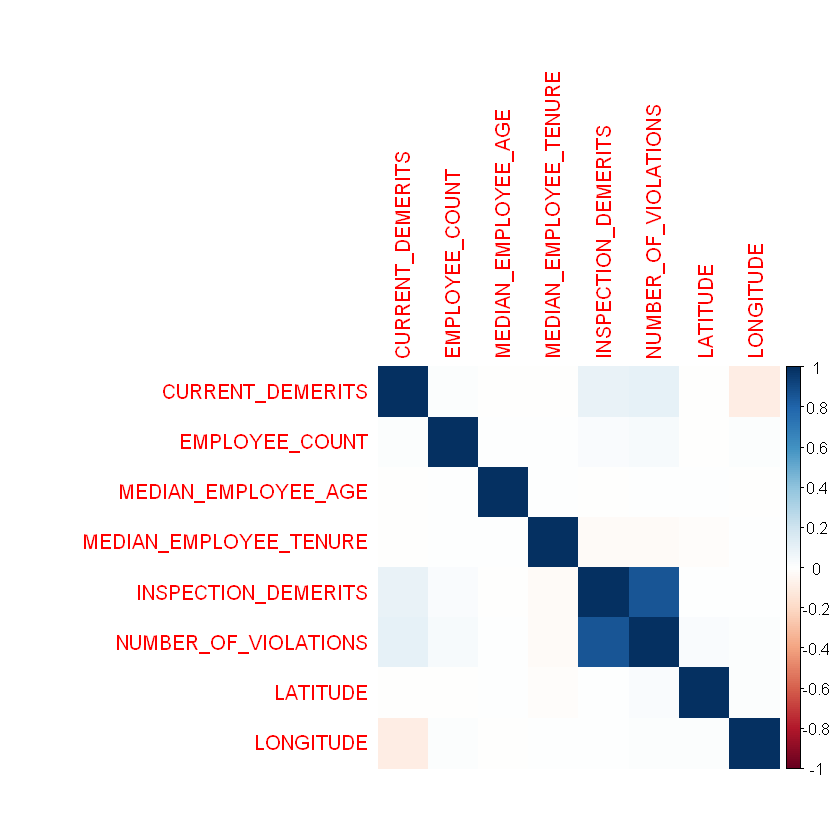

In [21]:
library(corrplot)
(cor.data<-cor(tr.dat[, -c(1,6,8:10,12)]))
corrplot(cor.data, method= 'color')

## EDA- Normalization of numerical independant data.
There could be a bias in certain columns, thus I used a min max normalization:
\begin{equation*}
z = \frac{x-min(x)} {max(x)-min(x)}
\end{equation*}
Where min and max are the minimum and maximum values in x given its range.
Normalization of the data will let eliminate unit measurement of the data and will enable us to compare the columns easily. We will avoid normalization of column with factors and column with dependant variable.

In [22]:
#Normalize training data: 
tr.dat_norm <- normalize(tr.dat[,-c(1,6,8:10,12)], method = "standardize", range = c(0, 1), margin = 1L, on.constant = "quiet")
tr.dat<- data.frame(tr.dat_norm, RESTAURANT_CATEGORY=tr.dat$RESTAURANT_CATEGORY, INSPECTION_TYPE=tr.dat$INSPECTION_TYPE, FIRST_VIOLATION_TYPE= tr.dat$FIRST_VIOLATION_TYPE, SECOND_VIOLATION_TYPE=tr.dat$SECOND_VIOLATION_TYPE, THIRD_VIOLATION_TYPE=tr.dat$THIRD_VIOLATION_TYPE, NEXT_INSPECTION_GRADE_C_OR_BELOW=tr.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW)
# to take a brief look at the new values
tr.dat_cols<- sapply(tr.dat, is.numeric)#numeric columns
tr.dat_summarization<-(tr.dat[, tr.dat_cols])
summary(tr.dat_summarization)#summary of the numeric columns

 CURRENT_DEMERITS    EMPLOYEE_COUNT    MEDIAN_EMPLOYEE_AGE
 Min.   :-0.971267   Min.   :-1.3468   Min.   :-2.048104  
 1st Qu.:-0.971267   1st Qu.:-0.7872   1st Qu.:-0.691058  
 Median :-0.009425   Median :-0.1156   Median :-0.004957  
 Mean   : 0.000000   Mean   : 0.0000   Mean   : 0.000000  
 3rd Qu.: 0.567680   3rd Qu.: 0.6678   3rd Qu.: 0.687975  
 Max.   :18.265578   Max.   : 4.2493   Max.   : 4.429166  
 MEDIAN_EMPLOYEE_TENURE INSPECTION_DEMERITS NUMBER_OF_VIOLATIONS
 Min.   :-1.8850        Min.   :-1.5939     Min.   :-1.4152     
 1st Qu.:-0.7321        1st Qu.:-0.6460     1st Qu.:-0.8644     
 Median :-0.1672        Median :-0.4091     Median :-0.3136     
 Mean   : 0.0000        Mean   : 0.0000     Mean   : 0.0000     
 3rd Qu.: 0.5508        3rd Qu.: 0.6573     3rd Qu.: 0.5126     
 Max.   : 6.1935        Max.   : 8.5956     Max.   : 9.3252     
    LATITUDE          LONGITUDE         NEXT_INSPECTION_GRADE_C_OR_BELOW
 Min.   :-6.50271   Min.   :-10.69161   Min.   :0.0000     

## EDA- Outliers
Outliers can be used exploring finer patterns. However, outliers can also lead to a bias. For this dataset, for initial exploration, I am removing outliers of the column: GarageSquareFeet because it has one observation at an extremity.

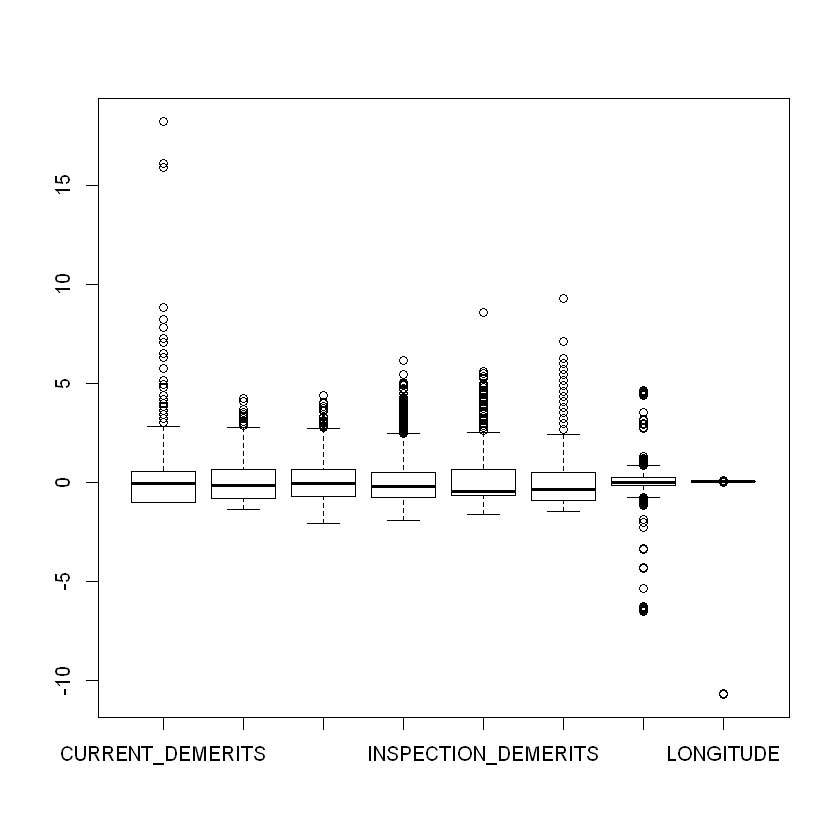

In [23]:
boxplot(tr.dat[,-c(9:14)])# check for the outliers

In [24]:
#current demerits have outliers and we need to remove it
Q <- quantile(tr.dat$CURRENT_DEMERITS, probs=c(.25, .75), na.rm = FALSE)
# calculate Interquartile Range
iqr <- IQR(tr.dat$CURRENT_DEMERITS)
#  upper and lower range
up <-  Q[2]+1.5*iqr # Upper Range  
low<- Q[1]-1.5*iqr # Lower Rangeï»¿
#  (the removal)
tr.dat<- subset(tr.dat, tr.dat$CURRENT_DEMERITS > (Q[1] - 1.5*iqr) & tr.dat$CURRENT_DEMERITS < (Q[2]+1.5*iqr))
#________________________________________________________________________________________
Q <- quantile(tr.dat$LONGITUDE, probs=c(.25, .75), na.rm = FALSE)
# calculate Interquartile Range
iqr <- IQR(tr.dat$LONGITUDE)
#  upper and lower range
up <-  Q[2]+1.5*iqr # Upper Range  
low<- Q[1]-1.5*iqr # Lower Rangeï»¿
#  (the removal)
tr.dat<- subset(tr.dat, tr.dat$LONGITUDE > (Q[1] - 1.5*iqr) & tr.dat$LONGITUDE < (Q[2]+1.5*iqr))
#________________________________________________________________________________________

#INSPECTION_DEMERITS is highly correlated WITH NUMBER_OF_VIOLATIONS thus we will drop it
tr.dat = subset(tr.dat, select = -c(INSPECTION_DEMERITS))

## Test data treatment
Filling missing values to GRADE column with DEMERITS column

In [25]:
levels(ts.dat$CURRENT_GRADE)

#Filling number of demerits NA values with median values
med_A_demerits<-median(ts.dat[ts.dat$CURRENT_GRADE=="A", ts.dat$CURRENT_DEMERITS], na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS) & ts.dat$CURRENT_GRADE== "A", "CURRENT_DEMERITS"]<- med_A_demerits
#_____________________________________________________________________
med_B_demerits<-median(ts.dat[ts.dat$CURRENT_GRADE=="B", ts.dat$CURRENT_DEMERITS], na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS) & ts.dat$CURRENT_GRADE== "B", "CURRENT_DEMERITS"]<- med_B_demerits

#_____________________________________________________________________
med_C_demerits<-median(ts.dat[ts.dat$CURRENT_GRADE=="C", ts.dat$CURRENT_DEMERITS], na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS) & ts.dat$CURRENT_GRADE== "C", "CURRENT_DEMERITS"]<- med_C_demerits

#_____________________________________________________________________
med_N_demerits<-median(ts.dat[ts.dat$CURRENT_GRADE=="N", ts.dat$CURRENT_DEMERITS], na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS) & ts.dat$CURRENT_GRADE== "N", "CURRENT_DEMERITS"]<- med_N_demerits

#_____________________________________________________________________
med_O_demerits<-median(ts.dat[ts.dat$CURRENT_GRADE=="O", ts.dat$CURRENT_DEMERITS], na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS) & ts.dat$CURRENT_GRADE== "O", "CURRENT_DEMERITS"]<- med_O_demerits

#_____________________________________________________________________
med_X_demerits<-median(ts.dat[ts.dat$CURRENT_GRADE=="X", ts.dat$CURRENT_DEMERITS], na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS) & ts.dat$CURRENT_GRADE== "X", "CURRENT_DEMERITS"]<- med_X_demerits

colSums(is.na(ts.dat))
#train_data[is.na(train_data$CURRENT_DEMERITS)]

#inject median value in the remaining NA cells of CURRENT_DEMERITS
med_demerits<-median(ts.dat$CURRENT_DEMERITS, na.rm=TRUE)
ts.dat[is.na(ts.dat$CURRENT_DEMERITS), "CURRENT_DEMERITS"]<- med_demerits

[1] "A" "B" "C" "N" "O" "X"

RESTAURANT_CATEGORY                 CURRENT_DEMERITS 
                               0                                4 
                   CURRENT_GRADE                   EMPLOYEE_COUNT 
                              94                               30 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                              10                               86 
                 INSPECTION_TYPE              INSPECTION_DEMERITS 
                               0                               79 
            FIRST_VIOLATION_TYPE            SECOND_VIOLATION_TYPE 
                               0                                0 
            THIRD_VIOLATION_TYPE             NUMBER_OF_VIOLATIONS 
                               0                                0 
NEXT_INSPECTION_GRADE_C_OR_BELOW                         LATITUDE 
                               9                                6 
                       LONGITUDE 
                               6

NA in EMPLOYEE_COUNT depends on RESTAURANT_CATEGORY

In [26]:
levels(ts.dat$RESTAURANT_CATEGORY)

ts.dat[is.na(ts.dat$EMPLOYEE_COUNT)]
ts.dat[ts.dat$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Restaurant", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Restaurant", "EMPLOYEE_COUNT"]<- med_Restaurant_employee
#_____________________________________________________________________

med_snack_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Snack Bar", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Snack Bar", "EMPLOYEE_COUNT"]<- med_snack_employee
#_____________________________________________________________________

med_bar_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Bar / Tavern", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Bar / Tavern", "EMPLOYEE_COUNT"]<- med_bar_employee
#_____________________________________________________________________

med_kitchen_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Special Kitchen", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Special Kitchen", "EMPLOYEE_COUNT"]<- med_kitchen_employee
#_____________________________________________________________________

med_portable_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Portable Unit", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Portable Unit", "EMPLOYEE_COUNT"]<- med_portable_employee
#_____________________________________________________________________

med_Buffet_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Buffet", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Buffet", "EMPLOYEE_COUNT"]<- med_Buffet_employee
#_____________________________________________________________________

med_Seafood_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "EMPLOYEE_COUNT"]<- med_Seafood_employee
#_____________________________________________________________________

med_Institutional_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Institutional Food Service", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Institutional Food Service", "EMPLOYEE_COUNT"]<- med_Institutional_employee
#_____________________________________________________________________

med_Pantry_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Pantry", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Pantry", "EMPLOYEE_COUNT"]<- med_Pantry_employee
#_____________________________________________________________________

med_Concessions_employee<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Concessions", ts.dat$EMPLOYEE_COUNT], na.rm=TRUE)
ts.dat[is.na(ts.dat$EMPLOYEE_COUNT) & ts.dat$RESTAURANT_CATEGORY== "Concessions", "EMPLOYEE_COUNT"]<- med_Concessions_employee

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Bar / Tavern,0,A,NA,23.92381,0.8685311,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.12423,115.1685
Bar / Tavern,0,A,NA,34.14884,2.7686474,Routine Inspection,15,Major,Major,Major,7,0,36.15899,115.2028
Restaurant,6,A,NA,35.39626,4.6878622,Routine Inspection,17,Critical,Major,Major,11,0,36.10278,115.1360
Bar / Tavern,4,A,NA,23.61996,3.5574000,Routine Inspection,6,Non-Major,Non-Major,Major,3,0,36.11505,115.1718
Bar / Tavern,0,A,NA,30.79123,7.3649401,Routine Inspection,20,Critical,Major,Major,10,0,36.10969,115.1702
Restaurant,3,A,NA,19.11219,2.5743312,Routine Inspection,19,Critical,Critical,Major,8,0,36.14291,115.2084
Bar / Tavern,3,A,NA,19.87237,1.4866188,Routine Inspection,7,Major,Major,Non-Major,3,0,36.09935,115.1679
Bar / Tavern,0,A,NA,34.10782,3.2869842,Routine Inspection,19,Critical,Major,Major,7,0,36.11664,115.1929
Special Kitchen,0,A,NA,31.16266,1.8119606,Routine Inspection,19,Critical,Other,Major,6,0,36.11649,115.1411


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,10,A,37,33.09443,0.9286269,Routine Inspection,28,Critical,Other,Critical,8,0,36.17389,115.0813
Portable Unit,8,NA,13,31.57149,6.8902467,Re-inspection,28,Critical,Critical,Major,9,0,36.20386,115.2433
Portable Unit,0,A,18,26.16994,4.5670561,Routine Inspection,9,Critical,Major,Non-Major,3,0,36.01219,115.1740
Portable Unit,10,A,18,31.25908,8.1140807,Routine Inspection,10,Major,Major,Major,4,0,36.09075,115.1767
Portable Unit,37,X,14,31.21030,4.8344395,Routine Inspection,37,Major,Critical,Major,11,0,36.10203,115.0640
Portable Unit,0,A,18,31.34330,2.5575215,Routine Inspection,0,Critical,Major,Non-Major,4,0,36.10223,115.1746
Portable Unit,5,A,3,30.65360,3.7914503,Routine Inspection,19,Critical,Critical,Other,5,0,36.16912,115.1396
Portable Unit,3,A,30,22.99641,5.2041092,Routine Inspection,NA,Critical,Critical,Major,6,0,36.10790,115.0564
Portable Unit,6,A,3,27.36040,4.4809035,Routine Inspection,19,Critical,Critical,Major,8,0,36.15076,115.2056


MEDIAN_EMPLOYEE_AGE NA value treatment
MEDIAN_EMPLOYEE_AGE column is also affected by RESTAURANT_CATEGORY

In [27]:
levels(ts.dat$RESTAURANT_CATEGORY)

ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE)]
ts.dat[ts.dat$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Restaurant", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Restaurant", "MEDIAN_EMPLOYEE_AGE"]<- med_Restaurant_Ecount
#_____________________________________________________________________

med_bar_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Bar / Tavern", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Bar / Tavern", "MEDIAN_EMPLOYEE_AGE"]<- med_bar_Ecount
#_____________________________________________________________________

med_Buffet_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Buffet", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Buffet", "MEDIAN_EMPLOYEE_AGE"]<- med_Buffet_Ecount
#_____________________________________________________________________

med_snack_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Snack Bar", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Snack Bar", "MEDIAN_EMPLOYEE_AGE"]<- med_snack_Ecount
#_____________________________________________________________________

med_Kitchen_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Special Kitchen", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Special Kitchen", "MEDIAN_EMPLOYEE_AGE"]<- med_Kitchen_Ecount
#_____________________________________________________________________

med_Pantry_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Pantry", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Pantry", "MEDIAN_EMPLOYEE_AGE"]<- med_Pantry_Ecount
#_____________________________________________________________________

med_Seafood_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "MEDIAN_EMPLOYEE_AGE"]<- med_Seafood_Ecount
#_____________________________________________________________________

med_Portable_Ecount<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Portable Unit", ts.dat$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_AGE) & ts.dat$RESTAURANT_CATEGORY== "Portable Unit", "MEDIAN_EMPLOYEE_AGE"]<- med_Portable_Ecount

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Bar / Tavern,8,A,25,NA,4.147302,Re-inspection,14,Critical,Major,Major,9,0,36.15934,115.1459
Restaurant,9,B,18,NA,3.128517,Routine Inspection,20,Critical,Major,Major,10,0,36.27561,115.1804
Restaurant,9,A,7,NA,6.783645,Routine Inspection,37,Major,Critical,Major,15,0,36.21843,115.1210
Restaurant,9,A,14,NA,4.381331,Routine Inspection,7,Major,Non-Major,Non-Major,4,0,36.15884,115.1260
Snack Bar,5,A,14,NA,7.239608,Routine Inspection,16,Critical,Critical,Major,5,0,36.15947,115.1948
Restaurant,8,A,14,NA,1.445981,Routine Inspection,9,Major,Major,Non-Major,5,1,36.00153,115.1217
Special Kitchen,6,A,14,NA,1.309958,Routine Inspection,9,Critical,Major,Non-Major,3,0,36.11443,114.9235
Bar / Tavern,6,A,6,NA,2.603660,Routine Inspection,7,Major,Non-Major,Non-Major,4,0,36.12581,115.2265
Snack Bar,5,A,14,NA,1.377962,Routine Inspection,19,Critical,Major,Major,7,1,36.11443,114.9235


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,10,A,37,33.09443,0.9286269,Routine Inspection,28,Critical,Other,Critical,8,0,36.17389,115.0813
Portable Unit,8,NA,13,31.57149,6.8902467,Re-inspection,28,Critical,Critical,Major,9,0,36.20386,115.2433
Portable Unit,0,A,18,26.16994,4.5670561,Routine Inspection,9,Critical,Major,Non-Major,3,0,36.01219,115.1740
Portable Unit,10,A,18,31.25908,8.1140807,Routine Inspection,10,Major,Major,Major,4,0,36.09075,115.1767
Portable Unit,37,X,14,31.21030,4.8344395,Routine Inspection,37,Major,Critical,Major,11,0,36.10203,115.0640
Portable Unit,0,A,18,31.34330,2.5575215,Routine Inspection,0,Critical,Major,Non-Major,4,0,36.10223,115.1746
Portable Unit,5,A,3,30.65360,3.7914503,Routine Inspection,19,Critical,Critical,Other,5,0,36.16912,115.1396
Portable Unit,3,A,30,22.99641,5.2041092,Routine Inspection,NA,Critical,Critical,Major,6,0,36.10790,115.0564
Portable Unit,6,A,3,27.36040,4.4809035,Routine Inspection,19,Critical,Critical,Major,8,0,36.15076,115.2056


MEDIAN_EMPLOYEE_TENURE NA values are related to RESTAURANT_CATEGORY

In [28]:
levels(ts.dat$RESTAURANT_CATEGORY)

ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE)]
ts.dat[ts.dat$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Restaurant", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Restaurant", "MEDIAN_EMPLOYEE_TENURE"]<- med_Restaurant_Ecount2
#_____________________________________________________________________

med_bar_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Bar / Tavern", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Bar / Tavern", "MEDIAN_EMPLOYEE_TENURE"]<- med_bar_Ecount2
#_____________________________________________________________________

med_Buffet_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Buffet", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Buffet", "MEDIAN_EMPLOYEE_TENURE"]<- med_Buffet_Ecount2
#_____________________________________________________________________

med_snack_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Snack Bar", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Snack Bar", "MEDIAN_EMPLOYEE_TENURE"]<- med_snack_Ecount2
#_____________________________________________________________________

med_Kitchen_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Special Kitchen", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Special Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Kitchen_Ecount2
#_____________________________________________________________________

med_Pantry_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Pantry", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Pantry", "MEDIAN_EMPLOYEE_TENURE"]<- med_Pantry_Ecount2
#_____________________________________________________________________

med_Seafood_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "MEDIAN_EMPLOYEE_TENURE"]<- med_Seafood_Ecount2
#_____________________________________________________________________

med_Portable_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Portable Unit", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Portable Unit", "MEDIAN_EMPLOYEE_TENURE"]<- med_Portable_Ecount2
#_____________________________________________________________________

med_Other_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Other", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Other", "MEDIAN_EMPLOYEE_TENURE"]<- med_Other_Ecount2
#_____________________________________________________________________

med_Bakery_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Kitchen Bakery", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Kitchen Bakery", "MEDIAN_EMPLOYEE_TENURE"]<- med_Bakery_Ecount2
#_____________________________________________________________________

med_Elementary_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Elementary School Kitchen", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Elementary School Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Elementary_Ecount2
#_____________________________________________________________________

med_Vendor_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Food Trucks / Mobile Vendor", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Food Trucks / Mobile Vendor", "MEDIAN_EMPLOYEE_TENURE"]<- med_Vendor_Ecount2
#_____________________________________________________________________

med_Produce_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Produce Market", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Produce Market", "MEDIAN_EMPLOYEE_TENURE"]<- med_Produce_Ecount2
#_____________________________________________________________________

med_Bakery_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Bakery Sales", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Bakery Sales", "MEDIAN_EMPLOYEE_TENURE"]<- med_Bakery_Ecount2
#_____________________________________________________________________

med_Caterer_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Caterer", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Caterer", "MEDIAN_EMPLOYEE_TENURE"]<- med_Caterer_Ecount2
#_____________________________________________________________________

med_Vegetable_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Vegetable Prep", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Vegetable Prep", "MEDIAN_EMPLOYEE_TENURE"]<- med_Vegetable_Ecount2
#_____________________________________________________________________

med_Banquet_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Banquet Kitchen", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Banquet Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Banquet_Ecount2
#_____________________________________________________________________

med_Institutional_Ecount2<-median(ts.dat[ts.dat$RESTAURANT_CATEGORY=="Institutional Food Service", ts.dat$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
ts.dat[is.na(ts.dat$MEDIAN_EMPLOYEE_TENURE) & ts.dat$RESTAURANT_CATEGORY== "Institutional Food Service", "MEDIAN_EMPLOYEE_TENURE"]<- med_Institutional_Ecount2

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Restaurant,9,A,18,28.06213,NA,Routine Inspection,9,Major,Major,Major,5,0,36.04080,115.0999
Restaurant,9,A,17,22.17312,NA,Routine Inspection,11,Major,Major,Major,5,0,36.11406,115.1730
Restaurant,3,A,3,22.83548,NA,Routine Inspection,14,Critical,Major,Major,7,0,36.26252,115.2067
Restaurant,6,A,11,38.14146,NA,Routine Inspection,19,Critical,Critical,Major,11,0,36.27687,115.2079
Bar / Tavern,10,A,9,29.04087,NA,Routine Inspection,NA,Major,Non-Major,Non-Major,3,0,36.10223,115.1746
Bar / Tavern,9,A,8,26.97175,NA,Routine Inspection,17,Critical,Major,Major,7,0,36.15917,115.1646
Produce Market,3,A,32,23.55173,NA,Routine Inspection,3,Non-Major,Non-Major,Non-Major,3,0,36.04041,115.1191
Restaurant,0,A,9,24.73099,NA,Routine Inspection,28,Critical,Major,Major,11,0,36.11222,115.2418
Restaurant,8,A,17,24.70263,NA,Routine Inspection,10,Critical,Major,Non-Major,4,1,36.14459,115.2400


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,10,A,37,33.09443,0.9286269,Routine Inspection,28,Critical,Other,Critical,8,0,36.17389,115.0813
Portable Unit,8,NA,13,31.57149,6.8902467,Re-inspection,28,Critical,Critical,Major,9,0,36.20386,115.2433
Portable Unit,0,A,18,26.16994,4.5670561,Routine Inspection,9,Critical,Major,Non-Major,3,0,36.01219,115.1740
Portable Unit,10,A,18,31.25908,8.1140807,Routine Inspection,10,Major,Major,Major,4,0,36.09075,115.1767
Portable Unit,37,X,14,31.21030,4.8344395,Routine Inspection,37,Major,Critical,Major,11,0,36.10203,115.0640
Portable Unit,0,A,18,31.34330,2.5575215,Routine Inspection,0,Critical,Major,Non-Major,4,0,36.10223,115.1746
Portable Unit,5,A,3,30.65360,3.7914503,Routine Inspection,19,Critical,Critical,Other,5,0,36.16912,115.1396
Portable Unit,3,A,30,22.99641,5.2041092,Routine Inspection,NA,Critical,Critical,Major,6,0,36.10790,115.0564
Portable Unit,6,A,3,27.36040,4.4809035,Routine Inspection,19,Critical,Critical,Major,8,0,36.15076,115.2056


NA treatment for INSPECTION_DEMERITS

In [29]:
med_INSPECTION_DEMERITS_Ecount2<-median(ts.dat$INSPECTION_DEMERITS, na.rm=TRUE)
ts.dat[is.na(ts.dat$INSPECTION_DEMERITS), "INSPECTION_DEMERITS"]<- med_INSPECTION_DEMERITS_Ecount2

NA in latitude and longitude

In [30]:
med_lat<-median(ts.dat$LATITUDE, na.rm=TRUE)
ts.dat[is.na(ts.dat$LATITUDE), "LATITUDE"]<- med_lat
med_lon<-median(ts.dat$LONGITUDE, na.rm=TRUE)
ts.dat[is.na(ts.dat$LONGITUDE), "LONGITUDE"]<- med_lon

CURRENT_DEMERITS and CURRENT_GRADE are highly correlated thus we will remove the current grade column as it also has NAs

In [31]:
ts.dat<-subset(ts.dat, select = -c(CURRENT_GRADE))

NEXT_INSPECTION_GRADE_C_OR_BELOW NA values

In [32]:
ts.dat<- na.omit(ts.dat)

Normalization

 CURRENT_DEMERITS   EMPLOYEE_COUNT    MEDIAN_EMPLOYEE_AGE
 Min.   :-1.01281   Min.   :-1.3452   Min.   :-2.04126   
 1st Qu.:-0.81428   1st Qu.:-0.7868   1st Qu.:-0.70382   
 Median :-0.02018   Median :-0.1168   Median :-0.01554   
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000   
 3rd Qu.: 0.57540   3rd Qu.: 0.6648   3rd Qu.: 0.69902   
 Max.   :18.83977   Max.   : 3.7916   Max.   : 3.46353   
 MEDIAN_EMPLOYEE_TENURE INSPECTION_DEMERITS NUMBER_OF_VIOLATIONS
 Min.   :-1.8986        Min.   :-1.6254     Min.   :-1.4641     
 1st Qu.:-0.7113        1st Qu.:-0.6739     1st Qu.:-0.6223     
 Median :-0.1527        Median :-0.4360     Median :-0.3417     
 Mean   : 0.0000        Mean   : 0.0000     Mean   : 0.0000     
 3rd Qu.: 0.5170        3rd Qu.: 0.6344     3rd Qu.: 0.5001     
 Max.   : 6.1303        Max.   : 7.5327     Max.   : 5.5507     
    LATITUDE         LONGITUDE         NEXT_INSPECTION_GRADE_C_OR_BELOW
 Min.   :-6.2557   Min.   :-10.79166   Min.   :0.0000              

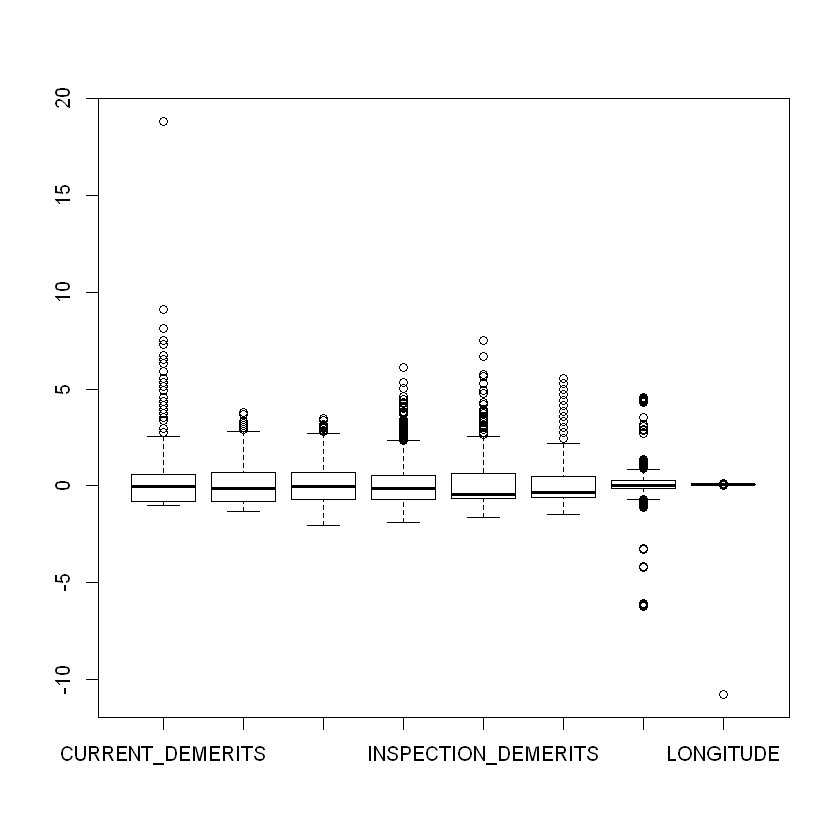

In [33]:
#Normalize training data: 
ts.dat_norm <- normalize(ts.dat[,-c(1,6,8:10,12)], method = "standardize", range = c(0, 1), margin = 1L, on.constant = "quiet")
ts.dat<- data.frame(ts.dat_norm, RESTAURANT_CATEGORY=ts.dat$RESTAURANT_CATEGORY, INSPECTION_TYPE=ts.dat$INSPECTION_TYPE, FIRST_VIOLATION_TYPE= ts.dat$FIRST_VIOLATION_TYPE, SECOND_VIOLATION_TYPE=ts.dat$SECOND_VIOLATION_TYPE, THIRD_VIOLATION_TYPE=ts.dat$THIRD_VIOLATION_TYPE, NEXT_INSPECTION_GRADE_C_OR_BELOW=ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW)
# to take a brief look at the new values
ts.dat_cols<- sapply(ts.dat, is.numeric)#numeric columns
ts.dat_summarization<-(ts.dat[, ts.dat_cols])
summary(ts.dat_summarization)#summary of the numeric columns

#Check outliers
boxplot(ts.dat[,-c(9:14)])# check for the outliers

#INSPECTION_DEMERITS is highly correlated WITH NUMBER_OF_VIOLATIONS thus we will drop it
ts.dat = subset(ts.dat, select = -c(INSPECTION_DEMERITS))

## MVP Model
Looking at the dataset, I first tried using the linear classifier (logistic regression) but the results were not promising. Thus Instead of going further with any other linear model (like SVM linear kernal), I decided to go with non-linear models.

I had high expectations with non linear kernal Support Vector Machine Model, but with my experience, I expected that SCM Non Linear Kernal Model require more time and experiements.

With such low performance of SVM non linear model, I decided to use K Nearest Neighbors model (Non-Parametric Model) which finds its own pattern using Eucledian Distance in which the distance between points p and q calculated as,

\begin{equation}
    d(p,q) = \sqrt{\sum_{n=1}^{n} (p_i - q_i)^2}
\end{equation}

To check if other nonlinear classifiers that make predictions based on features instead of distance/similarity, can give better results, I also tried Decision Tree and simple Neural Network, but none of them beat KNN in terms of accuracy. Thus, instead of exploring any further, I decided to tune the K-value and compared accuracies among various values of K. For total three nearest neighbors, KNN gave the best accuracy while prediction.

As the data looks imbalanced we should consider using MCC for the prediction modeling. I will use MCC (Matthews Correlation Coefficient) to compare the models among each other and choose the best with highest MCC. It can be calculated with the following formula:

\begin{equation}
MCC = \frac{(TP*TN)-(FP*FN)}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
\end{equation}


In [34]:
#Function for MCC
z<-1.96 #value of z for the CI intervals 95%
Matt_Coef <- function (conf_matrix)#function for MCC
{
  TP <- conf_matrix$table[1,1]
  TN <- conf_matrix$table[2,2]
  FP <- conf_matrix$table[1,2]
  FN <- conf_matrix$table[2,1]

  mcc_num <- (TP*TN - FP*FN)
  mcc_den <- as.double((TP+FP))*as.double((TP+FN))*as.double((TN+FP))*as.double((TN+FN))

  mcc_final <- mcc_num/sqrt(mcc_den)
  return(mcc_final)
}

#arrays for the accuracies later used in the table of accuracies
array_accuracy <- c()
array_sensitivity <- c()
array_balanced <- c()
array_f1 <- c()
array_mcc <- c()

### Logistic Regression

In [35]:
logis.prob<- glm(NEXT_INSPECTION_GRADE_C_OR_BELOW~., family= binomial(link='logit'), data = tr.dat)
summary(logis.prob)


Call:
glm(formula = NEXT_INSPECTION_GRADE_C_OR_BELOW ~ ., family = binomial(link = "logit"), 
    data = tr.dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3288  -0.6158  -0.5644  -0.4835   2.4873  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                     -1.465880   1.096317  -1.337
CURRENT_DEMERITS                                -0.006494   0.038758  -0.168
EMPLOYEE_COUNT                                  -0.044085   0.027819  -1.585
MEDIAN_EMPLOYEE_AGE                             -0.030327   0.027699  -1.095
MEDIAN_EMPLOYEE_TENURE                           0.005530   0.027770   0.199
NUMBER_OF_VIOLATIONS                             0.162910   0.034479   4.725
LATITUDE                                        -0.045453   0.068574  -0.663
LONGITUDE                                       -7.920338   9.447995  -0.838
RESTAURANT_CATEGORYBanquet Kitchen              -0.629442   0.94

In [36]:
# Predicted probability
logis.prob <- predict(logis.prob, ts.dat, type="response")

# Classification (y_hat)
logis.pred <- ifelse(logis.prob >= 0.5, 1, 0)

# confusionMatrix function takes only factor values for yhat and y.
logis.conf <- confusionMatrix(factor(logis.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive = "1")

logis.conf

logis_accuracy <-logis.conf$overall['Accuracy'] #accuracy
array_accuracy[1]<- c(logis_accuracy)#array of accuracies

logis_Sensitivity <-logis.conf$byClass[ "Sensitivity"]
array_sensitivity[1]<-c(logis_Sensitivity) 

logis_balanced <-logis.conf$byClass[ "Balanced Accuracy"]
array_balanced[1]<- logis_balanced

logis_f1 <-logis.conf$byClass[ "F1"]
array_f1[1]<- logis_f1

logis_mcc <- Matt_Coef(logis.conf)
array_mcc[1]<-logis_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3921  730
         1   37    5
                                         
               Accuracy : 0.8366         
                 95% CI : (0.8257, 0.847)
    No Information Rate : 0.8434         
    P-Value [Acc > NIR] : 0.9036         
                                         
                  Kappa : -0.0041        
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.006803       
            Specificity : 0.990652       
         Pos Pred Value : 0.119048       
         Neg Pred Value : 0.843045       
             Prevalence : 0.156616       
         Detection Rate : 0.001065       
   Detection Prevalence : 0.008949       
      Balanced Accuracy : 0.498727       
                                         
       'Positive' Class : 1              
                                         

### Quadratic discriminant analysis

In [37]:
qda.fit <- qda(NEXT_INSPECTION_GRADE_C_OR_BELOW ~ CURRENT_DEMERITS+ EMPLOYEE_COUNT+ MEDIAN_EMPLOYEE_AGE+ MEDIAN_EMPLOYEE_TENURE+ NUMBER_OF_VIOLATIONS+ LATITUDE+ LONGITUDE, data = tr.dat)
qda.pred <- predict(qda.fit, ts.dat)$class

qda.conf <- confusionMatrix(factor(qda.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
qda.conf

qda_accuracy <-qda.conf$overall['Accuracy'] #accuracy
array_accuracy[2]<- c(qda_accuracy)#array of accuracies

qda_Sensitivity <-qda.conf$byClass[ "Sensitivity"]
array_sensitivity[2]<-c(qda_Sensitivity) 

qda_balanced <-qda.conf$byClass[ "Balanced Accuracy"]
array_balanced[2]<- qda_balanced

qda_f1 <-qda.conf$byClass[ "F1"]
array_f1[2]<- qda_f1

qda_mcc <- Matt_Coef(qda.conf)
array_mcc[2]<-qda_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3896  702
         1   62   33
                                          
               Accuracy : 0.8372          
                 95% CI : (0.8263, 0.8477)
    No Information Rate : 0.8434          
    P-Value [Acc > NIR] : 0.8816          
                                          
                  Kappa : 0.0453          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.044898        
            Specificity : 0.984336        
         Pos Pred Value : 0.347368        
         Neg Pred Value : 0.847325        
             Prevalence : 0.156616        
         Detection Rate : 0.007032        
   Detection Prevalence : 0.020243        
      Balanced Accuracy : 0.514617        
                                          
       'Positive' Class : 1               
                        

### Support Vector Machine, Nonlinear kernel

In [38]:
library(e1071)
# To identify the types of kernel, type  ??svm in the Console
svm2.fit = svm(factor(NEXT_INSPECTION_GRADE_C_OR_BELOW) ~., data = tr.dat, kernel = "radial", cost = 1000, scale = FALSE)
summary(svm2.fit)


Attaching package: 'e1071'


The following objects are masked from 'package:PerformanceAnalytics':

    kurtosis, skewness





Call:
svm(formula = factor(NEXT_INSPECTION_GRADE_C_OR_BELOW) ~ ., data = tr.dat, 
    kernel = "radial", cost = 1000, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1000 

Number of Support Vectors:  4137

 ( 2551 1586 )


Number of Classes:  2 

Levels: 
 0 1




In [39]:
svm2.pred <- predict(svm2.fit, newdata = ts.dat[-c(13)])
svm2.conf <- confusionMatrix(factor(svm2.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
svm2.conf

svm2_accuracy <-svm2.conf$overall['Accuracy'] #accuracy
array_accuracy[3]<- c(svm2_accuracy)#array of accuracies

svm2_Sensitivity <-svm2.conf$byClass[ "Sensitivity"]
array_sensitivity[3]<-c(svm2_Sensitivity) 

svm2_balanced <-svm2.conf$byClass[ "Balanced Accuracy"]
array_balanced[3]<- svm2_balanced

svm2_f1 <-svm2.conf$byClass[ "F1"]
array_f1[3]<- svm2_f1

svm2_mcc <- Matt_Coef(svm2.conf)
array_mcc[3]<-svm2_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3908  720
         1   50   15
                                         
               Accuracy : 0.8359         
                 95% CI : (0.825, 0.8464)
    No Information Rate : 0.8434         
    P-Value [Acc > NIR] : 0.9224         
                                         
                  Kappa : 0.0124         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.020408       
            Specificity : 0.987367       
         Pos Pred Value : 0.230769       
         Neg Pred Value : 0.844425       
             Prevalence : 0.156616       
         Detection Rate : 0.003196       
   Detection Prevalence : 0.013850       
      Balanced Accuracy : 0.503888       
                                         
       'Positive' Class : 1              
                                         

### Decision Tree

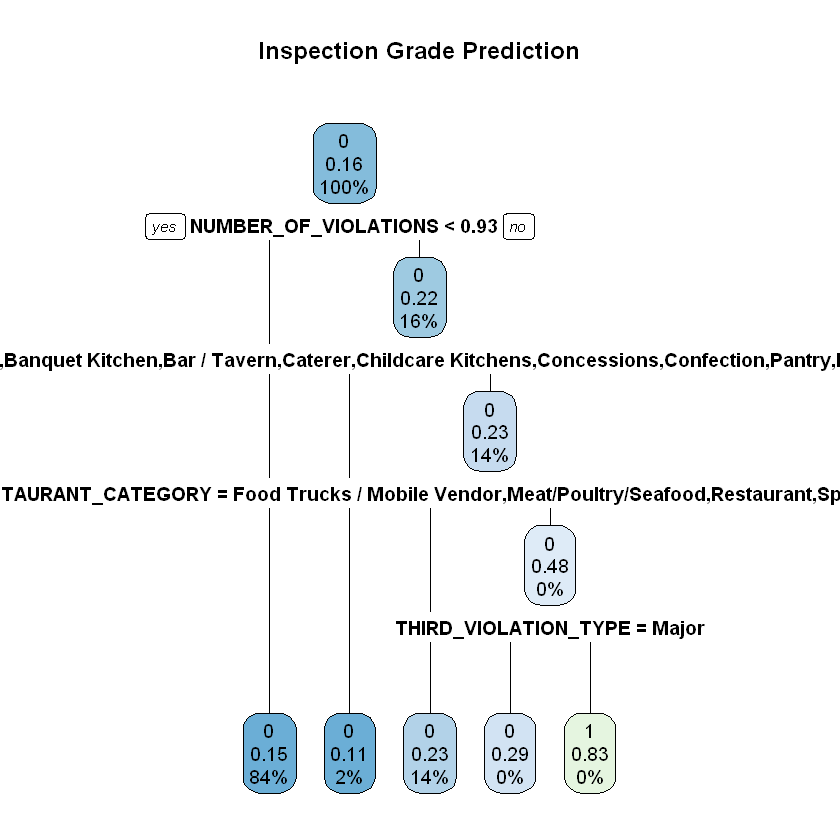

In [40]:
# Decision tree can be implemented using tree, rpart, ... packages
library(rpart)
library(rpart.plot)

dc.fit <- rpart(factor(NEXT_INSPECTION_GRADE_C_OR_BELOW) ~., data=tr.dat, method="class",control=rpart.control(minsplit=30, cp=0.001))

rpart.plot(dc.fit, main ="Inspection Grade Prediction")

In [41]:
dc.prune.fit <- prune(dc.fit, dc.fit$cptable[which.min(dc.fit$cptable[,"xerror"]),"CP"])
summary(dc.prune.fit)

Call:
rpart(formula = factor(NEXT_INSPECTION_GRADE_C_OR_BELOW) ~ ., 
    data = tr.dat, method = "class", control = rpart.control(minsplit = 30, 
        cp = 0.001))
  n= 10021 

           CP nsplit rel error xerror       xstd
1 0.001257071      0         1      1 0.02299446

Node number 1: 10021 observations
  predicted class=0  expected loss=0.1587666  P(node) =1
    class counts:  8430  1591
   probabilities: 0.841 0.159 



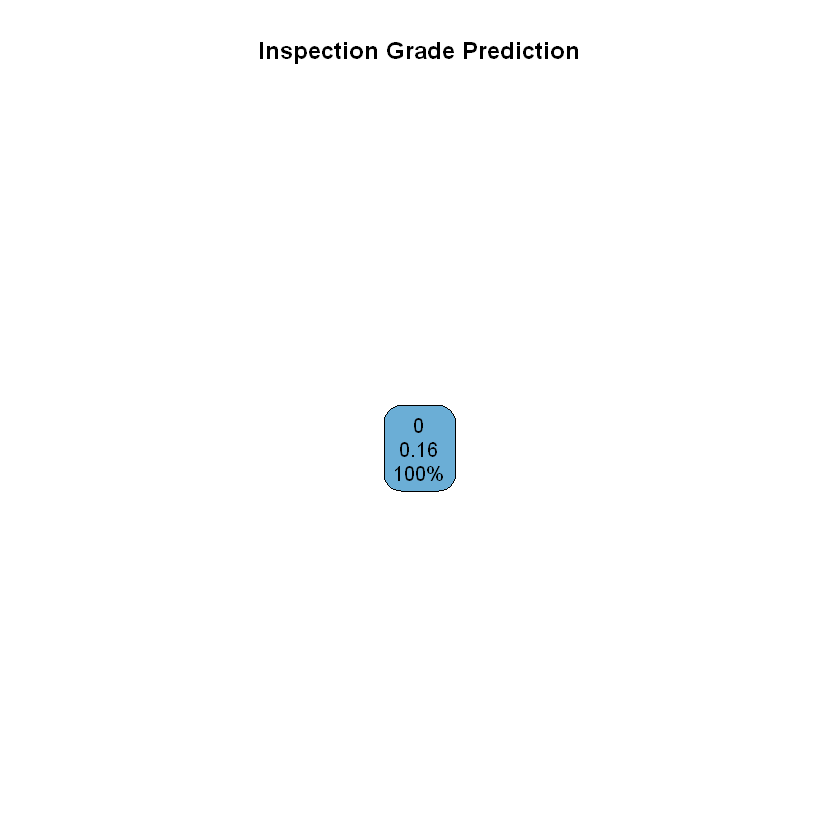

In [42]:
rpart.plot(dc.prune.fit, main ="Inspection Grade Prediction")

In [43]:
dc.pred <- predict(dc.prune.fit, newdata = ts.dat[-c(13)], type = "class")
dc.conf <- confusionMatrix(factor(dc.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
dc.conf

dc_accuracy <-dc.conf$overall['Accuracy'] #accuracy
array_accuracy[4]<- c(dc_accuracy)#array of accuracies

dc_Sensitivity <-dc.conf$byClass[ "Sensitivity"]
array_sensitivity[4]<-c(dc_Sensitivity) 

dc_balanced <-dc.conf$byClass[ "Balanced Accuracy"]
array_balanced[4]<- dc_balanced

dc_f1 <-dc.conf$byClass[ "F1"]
array_f1[4]<- dc_f1

dc_mcc <- Matt_Coef(dc.conf)
array_mcc[4]<-dc_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3958  735
         1    0    0
                                          
               Accuracy : 0.8434          
                 95% CI : (0.8327, 0.8537)
    No Information Rate : 0.8434          
    P-Value [Acc > NIR] : 0.5098          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.8434          
             Prevalence : 0.1566          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 1               
                        

### Radnom Forest

In [44]:
library(randomForest)

rf.fit= randomForest(factor(NEXT_INSPECTION_GRADE_C_OR_BELOW)~., data = tr.dat, ntree = 50, mtry = ceiling(sqrt(ncol(tr.dat))))
rf.fit
summary(rf.fit)


Call:
 randomForest(formula = factor(NEXT_INSPECTION_GRADE_C_OR_BELOW) ~      ., data = tr.dat, ntree = 50, mtry = ceiling(sqrt(ncol(tr.dat)))) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 4

        OOB estimate of  error rate: 16.54%
Confusion matrix:
     0  1 class.error
0 8340 90  0.01067616
1 1567 24  0.98491515

                Length Class  Mode     
call                5  -none- call     
type                1  -none- character
predicted       10021  factor numeric  
err.rate          150  -none- numeric  
confusion           6  -none- numeric  
votes           20042  matrix numeric  
oob.times       10021  -none- numeric  
classes             2  -none- character
importance         12  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               10021  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

In [45]:
rf.pred = predict(rf.fit, ts.dat[-c(13)], type ="response")
rf.conf <- confusionMatrix(factor(rf.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
rf.conf

rf_accuracy <-rf.conf$overall['Accuracy'] #accuracy
array_accuracy[5]<- c(rf_accuracy)#array of accuracies

rf_Sensitivity <-rf.conf$byClass[ "Sensitivity"]
array_sensitivity[5]<-c(rf_Sensitivity) 

rf_balanced <-rf.conf$byClass[ "Balanced Accuracy"]
array_balanced[5]<- rf_balanced

rf_f1 <-rf.conf$byClass[ "F1"]
array_f1[5]<- rf_f1

rf_mcc <- Matt_Coef(rf.conf)
array_mcc[5]<-rf_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3942  729
         1   16    6
                                          
               Accuracy : 0.8413          
                 95% CI : (0.8305, 0.8516)
    No Information Rate : 0.8434          
    P-Value [Acc > NIR] : 0.6648          
                                          
                  Kappa : 0.0068          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.008163        
            Specificity : 0.995958        
         Pos Pred Value : 0.272727        
         Neg Pred Value : 0.843931        
             Prevalence : 0.156616        
         Detection Rate : 0.001278        
   Detection Prevalence : 0.004688        
      Balanced Accuracy : 0.502060        
                                          
       'Positive' Class : 1               
                        

### Neural network 

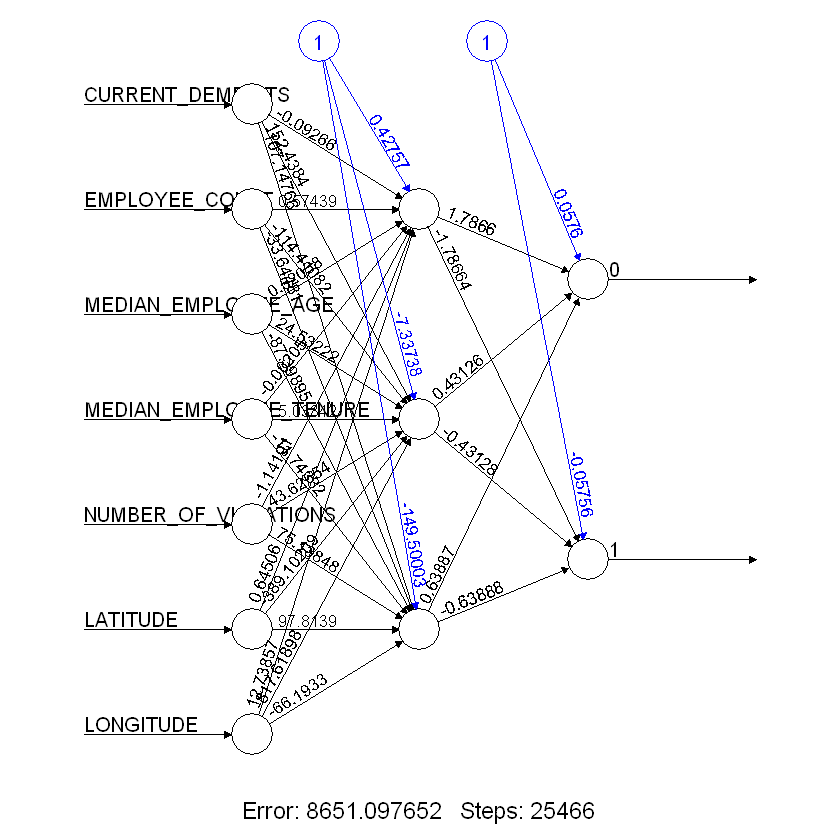

In [47]:
library(neuralnet)
set.seed(12345)

## hidden =c(5,3): layer 1 has 5 nodes, layer 2 has 3 nodes
n <- names(tr.dat[-c(8:12)])
nn.fit <- neuralnet(factor(NEXT_INSPECTION_GRADE_C_OR_BELOW) ~., data = tr.dat[-c(8:12)], hidden=c(3), linear.output = FALSE, err.fc = "ce", likelihood = TRUE)

plot(nn.fit, rep ="best")

In [48]:
nn.prob <- compute(nn.fit, ts.dat[-c(13)])

nn.pred <- ifelse(nn.prob$net.result[,2] >= 0.5, 1,0)
nn.conf <- confusionMatrix(factor(nn.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
nn.conf

nn_accuracy <-nn.conf$overall['Accuracy'] #accuracy
array_accuracy[6]<- c(nn_accuracy)#array of accuracies

nn_Sensitivity <-nn.conf$byClass[ "Sensitivity"]
array_sensitivity[6]<-c(nn_Sensitivity) 

nn_balanced <-nn.conf$byClass[ "Balanced Accuracy"]
array_balanced[6]<- nn_balanced

nn_f1 <-nn.conf$byClass[ "F1"]
array_f1[6]<- nn_f1

nn_mcc <- Matt_Coef(nn.conf)
array_mcc[6]<-nn_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3958  735
         1    0    0
                                          
               Accuracy : 0.8434          
                 95% CI : (0.8327, 0.8537)
    No Information Rate : 0.8434          
    P-Value [Acc > NIR] : 0.5098          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.8434          
             Prevalence : 0.1566          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 1               
                        

### K-Nearest Neighbors (KNN)

In [49]:
# The knn function is available in the class package
knn.pred <- knn(tr.dat[-c(8:12)], ts.dat[-c(8:12)], cl = tr.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW, k=3)
knn.conf <- confusionMatrix(factor(knn.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
knn.conf

knn_accuracy <-knn.conf$overall['Accuracy'] #accuracy
array_accuracy[7]<- c(knn_accuracy)#array of accuracies

knn_Sensitivity <-knn.conf$byClass[ "Sensitivity"]
array_sensitivity[7]<-c(knn_Sensitivity) 

knn_balanced <-knn.conf$byClass[ "Balanced Accuracy"]
array_balanced[7]<- knn_balanced

knn_f1 <-knn.conf$byClass[ "F1"]
array_f1[7]<- knn_f1

knn_mcc <- Matt_Coef(knn.conf)
array_mcc[7]<-knn_mcc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3958   55
         1    0  680
                                          
               Accuracy : 0.9883          
                 95% CI : (0.9848, 0.9912)
    No Information Rate : 0.8434          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9542          
                                          
 Mcnemar's Test P-Value : 3.305e-13       
                                          
            Sensitivity : 0.9252          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9863          
             Prevalence : 0.1566          
         Detection Rate : 0.1449          
   Detection Prevalence : 0.1449          
      Balanced Accuracy : 0.9626          
                                          
       'Positive' Class : 1               
                        

### Comparison of ML models
Shows that KNN predicts the best for the data.

In [50]:
array_names<- c( "LR", "QDA", "SVM", "DT", "RF","NN", "KNN")
evaluation_table<-data.frame(array_names,array_accuracy,array_sensitivity,array_balanced, array_f1, array_mcc)
evaluation_table

array_names,array_accuracy,array_sensitivity,array_balanced,array_f1,array_mcc
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LR,0.8365651,0.006802721,0.4987273,0.01287001,-0.009823035
QDA,0.8372043,0.044897959,0.5146167,0.07951807,0.075442458
SVM,0.8359258,0.020408163,0.5038878,0.03750000,0.024180077
DT,0.8433838,0.000000000,0.5000000,NA,NaN
RF,0.8412529,0.008163265,0.5020604,0.01585205,0.021925469
NN,0.8433838,0.000000000,0.5000000,NA,NaN
KNN,0.9882804,0.925170068,0.9625850,0.96113074,0.955243524


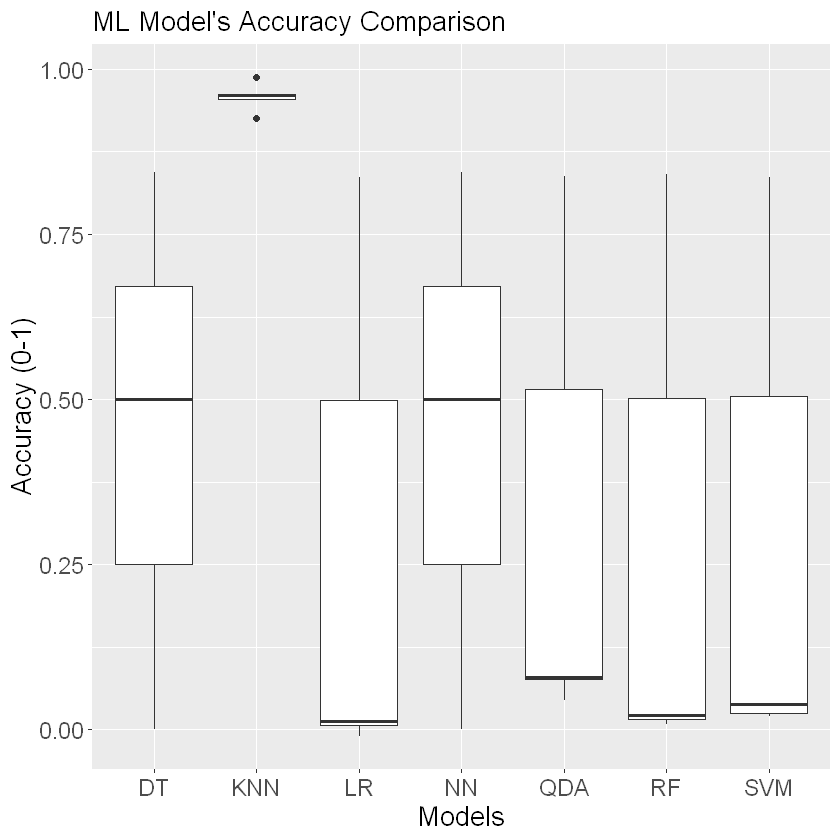

In [51]:
library(tidyverse)

Acc_Theme <- theme(plot.title = element_text(size = (16)), 
                 legend.title = element_text(colour = "steelblue",  face = "bold.italic", family = "Helvetica"), 
                 legend.text = element_text(face = "italic", colour="steelblue4",family = "Helvetica"), 
                  axis.title = element_text(size = (16)),
                  axis.text = element_text(size = (14)))

evaluation_table%>%
    gather(key = "fold", value = "accuracy", -array_names) %>%
    ggplot(aes(array_names, accuracy)) +
    geom_boxplot() +
    Acc_Theme+
    labs(title= "ML Model's Accuracy Comparison", y="Accuracy (0-1)", x = "Models")

### hyperparameter tuning of KNN
It shows that KNN works best for value of K=3

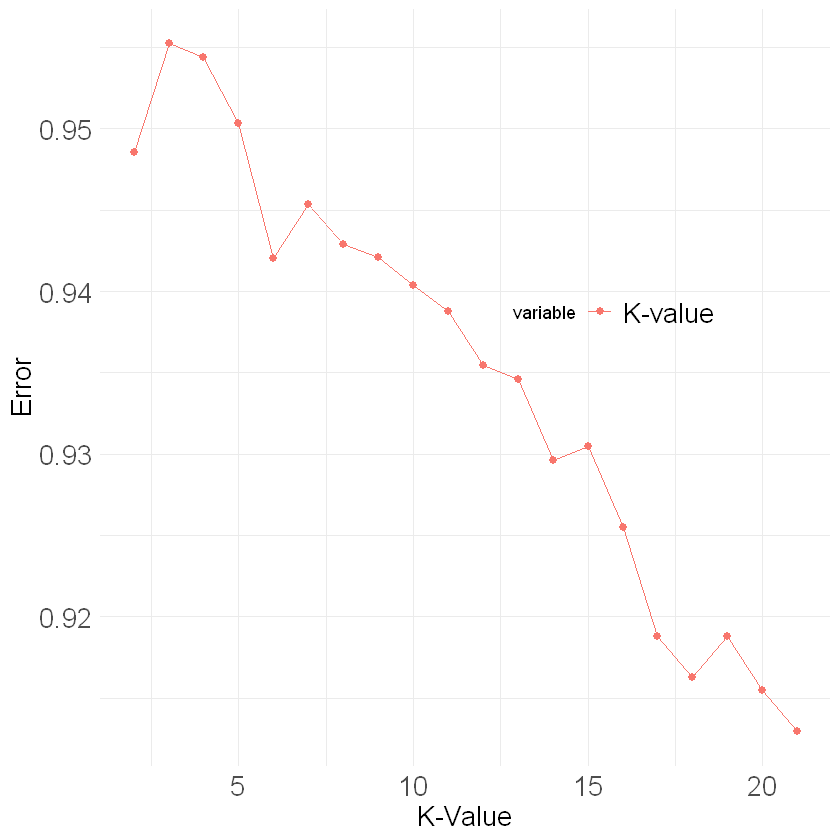

In [52]:
#KNN k value- came the best as k=3
options(digits = 10)
j=2
vector_acc<- c() #array for accuracy
vector_k<- c() #array for k value which is j

# A loop to check all the K values from 2 to 20 for error rates.
for(i in 1:20){
    #knn
    knn.pred <- knn(tr.dat[-c(8:12)], ts.dat[-c(8:12)], cl = tr.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW, k=j)
    knn.conf <- confusionMatrix(factor(knn.pred), factor(ts.dat$NEXT_INSPECTION_GRADE_C_OR_BELOW), positive ="1")
    knn.conf
    knn_mcc <- Matt_Coef(knn.conf)
    
    vector_acc[i]= knn_mcc #MCC accuracy stored in array
    vector_k[i]= j #k value stored in array
    
    j=j+1 #k value for next loop    
}

#Set the default theme
theme_set(
  theme_minimal() +
    theme(legend.position = "top")
  )
#Accuracy vs k-value plot
knn_tune<- data.frame(vector_k, vector_acc)
K_Value<-knn_tune$vector_k

ggplot(knn_tune, aes(x=K_Value, y = accuracy, color = variable)) + 
    geom_point(aes(y = vector_acc, col = "K-value"), size=3, shape=20)+
    geom_line(aes(y = vector_acc, col = "K-value"))+
    labs(x="K-Value", y="Error", 
       shape="Model type")+
    theme(legend.position = c(0.7, 0.6),legend.direction = "horizontal", axis.text=element_text(size=16),#for legends
            axis.title=element_text(size=16), 
              legend.text=element_text(size=16))

## Preparing whole data for training
Filling missing values to GRADE column with DEMERITS column

In [53]:
levels(df$CURRENT_GRADE)

#Filling number of demerits NA values with median values
med_A_demerits<-median(df[df$CURRENT_GRADE=="A", df$CURRENT_DEMERITS], na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS) & df$CURRENT_GRADE== "A", "CURRENT_DEMERITS"]<- med_A_demerits
#_____________________________________________________________________
med_B_demerits<-median(df[df$CURRENT_GRADE=="B", df$CURRENT_DEMERITS], na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS) & df$CURRENT_GRADE== "B", "CURRENT_DEMERITS"]<- med_B_demerits

#_____________________________________________________________________
med_C_demerits<-median(df[df$CURRENT_GRADE=="C", df$CURRENT_DEMERITS], na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS) & df$CURRENT_GRADE== "C", "CURRENT_DEMERITS"]<- med_C_demerits

#_____________________________________________________________________
med_N_demerits<-median(df[df$CURRENT_GRADE=="N", df$CURRENT_DEMERITS], na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS) & df$CURRENT_GRADE== "N", "CURRENT_DEMERITS"]<- med_N_demerits

#_____________________________________________________________________
med_O_demerits<-median(df[df$CURRENT_GRADE=="O", df$CURRENT_DEMERITS], na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS) & df$CURRENT_GRADE== "O", "CURRENT_DEMERITS"]<- med_O_demerits

#_____________________________________________________________________
med_X_demerits<-median(df[df$CURRENT_GRADE=="X", df$CURRENT_DEMERITS], na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS) & df$CURRENT_GRADE== "X", "CURRENT_DEMERITS"]<- med_X_demerits

colSums(is.na(df))
#train_data[is.na(train_data$CURRENT_DEMERITS)]

#inject median value in the remaining NA cells of CURRENT_DEMERITS
med_demerits<-median(df$CURRENT_DEMERITS, na.rm=TRUE)
df[is.na(df$CURRENT_DEMERITS), "CURRENT_DEMERITS"]<- med_demerits

[1] "A" "B" "C" "N" "O" "X"

RESTAURANT_CATEGORY                 CURRENT_DEMERITS 
                               0                                8 
                   CURRENT_GRADE                   EMPLOYEE_COUNT 
                             308                               93 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                              34                              297 
                 INSPECTION_TYPE              INSPECTION_DEMERITS 
                               0                              254 
            FIRST_VIOLATION_TYPE            SECOND_VIOLATION_TYPE 
                               0                                0 
            THIRD_VIOLATION_TYPE             NUMBER_OF_VIOLATIONS 
                               0                                0 
NEXT_INSPECTION_GRADE_C_OR_BELOW                         LATITUDE 
                              40                               18 
                       LONGITUDE 
                              18

NA in EMPLOYEE_COUNT depends on RESTAURANT_CATEGORY

In [54]:
levels(df$RESTAURANT_CATEGORY)

df[is.na(df$EMPLOYEE_COUNT)]
df[df$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_employee<-median(df[df$RESTAURANT_CATEGORY=="Restaurant", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Restaurant", "EMPLOYEE_COUNT"]<- med_Restaurant_employee
#_____________________________________________________________________

med_snack_employee<-median(df[df$RESTAURANT_CATEGORY=="Snack Bar", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Snack Bar", "EMPLOYEE_COUNT"]<- med_snack_employee
#_____________________________________________________________________

med_bar_employee<-median(df[df$RESTAURANT_CATEGORY=="Bar / Tavern", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Bar / Tavern", "EMPLOYEE_COUNT"]<- med_bar_employee
#_____________________________________________________________________

med_kitchen_employee<-median(df[df$RESTAURANT_CATEGORY=="Special Kitchen", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Special Kitchen", "EMPLOYEE_COUNT"]<- med_kitchen_employee
#_____________________________________________________________________

med_portable_employee<-median(df[df$RESTAURANT_CATEGORY=="Portable Unit", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Portable Unit", "EMPLOYEE_COUNT"]<- med_portable_employee
#_____________________________________________________________________

med_Buffet_employee<-median(df[df$RESTAURANT_CATEGORY=="Buffet", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Buffet", "EMPLOYEE_COUNT"]<- med_Buffet_employee
#_____________________________________________________________________

med_Seafood_employee<-median(df[df$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "EMPLOYEE_COUNT"]<- med_Seafood_employee
#_____________________________________________________________________

med_Institutional_employee<-median(df[df$RESTAURANT_CATEGORY=="Institutional Food Service", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Institutional Food Service", "EMPLOYEE_COUNT"]<- med_Institutional_employee
#_____________________________________________________________________

med_Pantry_employee<-median(df[df$RESTAURANT_CATEGORY=="Pantry", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Pantry", "EMPLOYEE_COUNT"]<- med_Pantry_employee
#_____________________________________________________________________

med_Concessions_employee<-median(df[df$RESTAURANT_CATEGORY=="Concessions", df$EMPLOYEE_COUNT], na.rm=TRUE)
df[is.na(df$EMPLOYEE_COUNT) & df$RESTAURANT_CATEGORY== "Concessions", "EMPLOYEE_COUNT"]<- med_Concessions_employee

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Snack Bar,9,A,NA,29.99044242,5.997696266,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.0837420,115.3068330
Restaurant,0,A,NA,28.16269792,2.091015237,Routine Inspection,14,Critical,Major,Major,9,1,36.1739662,115.1181233
Restaurant,6,A,NA,27.35956314,1.847999565,Routine Inspection,9,Major,Major,Major,7,0,36.0563527,115.2773493
Restaurant,0,A,NA,18.00000000,3.341284378,Routine Inspection,14,Critical,Major,Major,7,0,35.9711697,115.1642610
Buffet,0,A,NA,35.65659397,7.633497755,Routine Inspection,3,Non-Major,Non-Major,Non-Major,3,0,36.1073485,115.1765836
Restaurant,0,A,NA,21.87231189,5.454011883,Routine Inspection,20,Critical,Major,Non-Major,6,0,35.1541545,114.5734962
Restaurant,0,A,NA,26.74096235,6.364660229,Routine Inspection,3,Non-Major,Non-Major,Non-Major,3,0,36.2729348,115.0110197
Restaurant,8,A,NA,18.00000000,1.914523284,Routine Inspection,29,Critical,Major,Major,14,0,36.8040699,114.0620809
Bar / Tavern,0,A,NA,23.92380740,0.868531078,Routine Inspection,5,Major,Non-Major,Non-Major,3,0,36.1242284,115.1684696


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,8,A,21,34.60132686,1.622041566,Routine Inspection,38,Critical,Critical,Critical,15,1,36.2038620,115.2432571
Portable Unit,8,NA,22,19.84860735,3.202325950,Routine Inspection,27,Critical,Critical,Other,9,0,36.2177737,115.0934119
Portable Unit,10,A,37,33.09443265,0.928626911,Routine Inspection,28,Critical,Other,Critical,8,0,36.1738903,115.0812946
Portable Unit,8,NA,13,31.57149125,6.890246656,Re-inspection,28,Critical,Critical,Major,9,0,36.2038620,115.2432571
Portable Unit,6,A,5,32.25306598,4.699120685,Routine Inspection,9,Major,Major,Non-Major,5,1,36.1738903,115.0812946
Portable Unit,8,A,3,27.19227582,2.296374830,Routine Inspection,19,Critical,Critical,Major,8,0,36.1668200,115.1162230
Portable Unit,13,X,12,23.86579198,2.960373431,Routine Inspection,13,Critical,Critical,Major,7,0,36.2183591,115.1203421
Portable Unit,0,A,15,30.23753385,10.653661140,Routine Inspection,16,Major,Non-Major,Non-Major,5,0,36.1325407,115.1553299
Portable Unit,0,A,3,24.96078083,1.166515491,Routine Inspection,18,Critical,Critical,Critical,4,0,36.1881490,115.1851910


MEDIAN_EMPLOYEE_AGE NA value treatment
MEDIAN_EMPLOYEE_AGE column is also affected by RESTAURANT_CATEGORY

In [55]:
levels(df$RESTAURANT_CATEGORY)

df[is.na(df$MEDIAN_EMPLOYEE_AGE)]
df[df$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Restaurant", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Restaurant", "MEDIAN_EMPLOYEE_AGE"]<- med_Restaurant_Ecount
#_____________________________________________________________________

med_bar_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Bar / Tavern", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Bar / Tavern", "MEDIAN_EMPLOYEE_AGE"]<- med_bar_Ecount
#_____________________________________________________________________

med_Buffet_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Buffet", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Buffet", "MEDIAN_EMPLOYEE_AGE"]<- med_Buffet_Ecount
#_____________________________________________________________________

med_snack_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Snack Bar", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Snack Bar", "MEDIAN_EMPLOYEE_AGE"]<- med_snack_Ecount
#_____________________________________________________________________

med_Kitchen_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Special Kitchen", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Special Kitchen", "MEDIAN_EMPLOYEE_AGE"]<- med_Kitchen_Ecount
#_____________________________________________________________________

med_Pantry_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Pantry", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Pantry", "MEDIAN_EMPLOYEE_AGE"]<- med_Pantry_Ecount
#_____________________________________________________________________

med_Seafood_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "MEDIAN_EMPLOYEE_AGE"]<- med_Seafood_Ecount
#_____________________________________________________________________

med_Portable_Ecount<-median(df[df$RESTAURANT_CATEGORY=="Portable Unit", df$MEDIAN_EMPLOYEE_AGE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_AGE) & df$RESTAURANT_CATEGORY== "Portable Unit", "MEDIAN_EMPLOYEE_AGE"]<- med_Portable_Ecount

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Bar / Tavern,3,A,9,NA,1.911045545,Routine Inspection,12,Major,Major,Major,9,0,36.1960841,115.1024004
Restaurant,5,A,3,NA,2.744916027,Routine Inspection,10,Major,Major,Non-Major,6,0,36.0068684,115.1117730
Restaurant,3,A,3,NA,6.164824530,Routine Inspection,16,Critical,Critical,Major,6,1,36.1169916,115.1553396
Restaurant,3,A,15,NA,2.479089065,Routine Inspection,3,Non-Major,Non-Major,Non-Major,3,1,36.1116872,115.1728316
Restaurant,2,A,53,NA,4.057930476,Routine Inspection,10,Major,Non-Major,Non-Major,4,0,36.1078060,115.1370410
Bar / Tavern,0,A,9,NA,4.720643603,Routine Inspection,7,Non-Major,Non-Major,Major,3,0,36.1241977,115.0758045
Restaurant,3,A,15,NA,3.658435750,Routine Inspection,16,Major,Non-Major,Non-Major,10,0,36.2638710,115.2511700
Restaurant,0,A,14,NA,5.623954794,Routine Inspection,19,Critical,Critical,Major,8,0,36.0865493,115.2438663
Bar / Tavern,8,A,25,NA,4.147302107,Re-inspection,14,Critical,Major,Major,9,0,36.1593440,115.1458980


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,8,A,21,34.60132686,1.622041566,Routine Inspection,38,Critical,Critical,Critical,15,1,36.2038620,115.2432571
Portable Unit,8,NA,22,19.84860735,3.202325950,Routine Inspection,27,Critical,Critical,Other,9,0,36.2177737,115.0934119
Portable Unit,10,A,37,33.09443265,0.928626911,Routine Inspection,28,Critical,Other,Critical,8,0,36.1738903,115.0812946
Portable Unit,8,NA,13,31.57149125,6.890246656,Re-inspection,28,Critical,Critical,Major,9,0,36.2038620,115.2432571
Portable Unit,6,A,5,32.25306598,4.699120685,Routine Inspection,9,Major,Major,Non-Major,5,1,36.1738903,115.0812946
Portable Unit,8,A,3,27.19227582,2.296374830,Routine Inspection,19,Critical,Critical,Major,8,0,36.1668200,115.1162230
Portable Unit,13,X,12,23.86579198,2.960373431,Routine Inspection,13,Critical,Critical,Major,7,0,36.2183591,115.1203421
Portable Unit,0,A,15,30.23753385,10.653661140,Routine Inspection,16,Major,Non-Major,Non-Major,5,0,36.1325407,115.1553299
Portable Unit,0,A,3,24.96078083,1.166515491,Routine Inspection,18,Critical,Critical,Critical,4,0,36.1881490,115.1851910


MEDIAN_EMPLOYEE_TENURE NA values are related to RESTAURANT_CATEGORY

In [56]:
levels(df$RESTAURANT_CATEGORY)

df[is.na(df$MEDIAN_EMPLOYEE_TENURE)]
df[df$RESTAURANT_CATEGORY=="Portable Unit"]

med_Restaurant_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Restaurant", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Restaurant", "MEDIAN_EMPLOYEE_TENURE"]<- med_Restaurant_Ecount2
#_____________________________________________________________________

med_bar_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Bar / Tavern", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Bar / Tavern", "MEDIAN_EMPLOYEE_TENURE"]<- med_bar_Ecount2
#_____________________________________________________________________

med_Buffet_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Buffet", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Buffet", "MEDIAN_EMPLOYEE_TENURE"]<- med_Buffet_Ecount2
#_____________________________________________________________________

med_snack_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Snack Bar", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Snack Bar", "MEDIAN_EMPLOYEE_TENURE"]<- med_snack_Ecount2
#_____________________________________________________________________

med_Kitchen_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Special Kitchen", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Special Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Kitchen_Ecount2
#_____________________________________________________________________

med_Pantry_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Pantry", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Pantry", "MEDIAN_EMPLOYEE_TENURE"]<- med_Pantry_Ecount2
#_____________________________________________________________________

med_Seafood_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Meat/Poultry/Seafood", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Meat/Poultry/Seafood", "MEDIAN_EMPLOYEE_TENURE"]<- med_Seafood_Ecount2
#_____________________________________________________________________

med_Portable_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Portable Unit", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Portable Unit", "MEDIAN_EMPLOYEE_TENURE"]<- med_Portable_Ecount2
#_____________________________________________________________________

med_Other_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Other", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Other", "MEDIAN_EMPLOYEE_TENURE"]<- med_Other_Ecount2
#_____________________________________________________________________

med_Bakery_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Kitchen Bakery", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Kitchen Bakery", "MEDIAN_EMPLOYEE_TENURE"]<- med_Bakery_Ecount2
#_____________________________________________________________________

med_Elementary_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Elementary School Kitchen", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Elementary School Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Elementary_Ecount2
#_____________________________________________________________________

med_Vendor_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Food Trucks / Mobile Vendor", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Food Trucks / Mobile Vendor", "MEDIAN_EMPLOYEE_TENURE"]<- med_Vendor_Ecount2
#_____________________________________________________________________

med_Produce_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Produce Market", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Produce Market", "MEDIAN_EMPLOYEE_TENURE"]<- med_Produce_Ecount2
#_____________________________________________________________________

med_Bakery_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Bakery Sales", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Bakery Sales", "MEDIAN_EMPLOYEE_TENURE"]<- med_Bakery_Ecount2
#_____________________________________________________________________

med_Caterer_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Caterer", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Caterer", "MEDIAN_EMPLOYEE_TENURE"]<- med_Caterer_Ecount2
#_____________________________________________________________________

med_Vegetable_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Vegetable Prep", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Vegetable Prep", "MEDIAN_EMPLOYEE_TENURE"]<- med_Vegetable_Ecount2
#_____________________________________________________________________

med_Banquet_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Banquet Kitchen", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Banquet Kitchen", "MEDIAN_EMPLOYEE_TENURE"]<- med_Banquet_Ecount2
#_____________________________________________________________________

med_Institutional_Ecount2<-median(df[df$RESTAURANT_CATEGORY=="Institutional Food Service", df$MEDIAN_EMPLOYEE_TENURE], na.rm=TRUE)
df[is.na(df$MEDIAN_EMPLOYEE_TENURE) & df$RESTAURANT_CATEGORY== "Institutional Food Service", "MEDIAN_EMPLOYEE_TENURE"]<- med_Institutional_Ecount2

[1] "Bakery Sales"                "Banquet Kitchen"            
 [3] "Banquet Support"             "Bar / Tavern"               
 [5] "Barbeque"                    "Beer Bar"                   
 [7] "Buffet"                      "Caterer"                    
 [9] "Childcare Kitchens"          "Concessions"                
[11] "Confection"                  "Elementary School Kitchen"  
[13] "Farmers Market"              "Food Trucks / Mobile Vendor"
[15] "Garde Manger"                "Grocery Store Sampling"     
[17] "Institutional Food Service"  "Kitchen Bakery"             
[19] "Main Kitchen"                "Meat/Poultry/Seafood"       
[21] "Pantry"                      "Portable Bar"               
[23] "Portable Unit"               "Produce Market"             
[25] "Restaurant"                  "Self-Service Food Truck"    
[27] "Snack Bar"                   "Special Kitchen"            
[29] "Vegetable Prep"              "Other"

RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Snack Bar,3,A,3,29.68832642,NA,Routine Inspection,19,Critical,Critical,Major,5,0,36.1067320,115.1436243
Snack Bar,3,A,8,34.30329848,NA,Routine Inspection,9,Critical,Major,Non-Major,3,0,36.2005500,115.1966650
Restaurant,9,A,3,25.62749083,NA,Routine Inspection,9,Major,Major,Major,6,1,36.0713650,115.0722635
Restaurant,10,A,25,29.33211645,NA,Routine Inspection,10,Major,Major,Major,4,0,36.1266080,115.2252010
Restaurant,6,A,15,32.67355529,NA,Routine Inspection,10,Critical,Non-Major,Non-Major,6,0,36.1022287,115.1745851
Restaurant,25,X,3,26.44441272,NA,Routine Inspection,33,Critical,Critical,Critical,13,1,36.0446020,115.1009190
Bar / Tavern,6,A,15,33.46622569,NA,Routine Inspection,10,Major,Major,Major,4,0,36.1226902,115.1701939
Restaurant,9,A,18,28.06213478,NA,Routine Inspection,9,Major,Major,Major,5,0,36.0408030,115.0998510
Restaurant,5,A,20,35.47882309,NA,Routine Inspection,7,Major,Non-Major,Non-Major,4,0,36.1588341,115.1203502


RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW,LATITUDE,LONGITUDE
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
Portable Unit,8,A,21,34.60132686,1.622041566,Routine Inspection,38,Critical,Critical,Critical,15,1,36.2038620,115.2432571
Portable Unit,8,NA,22,19.84860735,3.202325950,Routine Inspection,27,Critical,Critical,Other,9,0,36.2177737,115.0934119
Portable Unit,10,A,37,33.09443265,0.928626911,Routine Inspection,28,Critical,Other,Critical,8,0,36.1738903,115.0812946
Portable Unit,8,NA,13,31.57149125,6.890246656,Re-inspection,28,Critical,Critical,Major,9,0,36.2038620,115.2432571
Portable Unit,6,A,5,32.25306598,4.699120685,Routine Inspection,9,Major,Major,Non-Major,5,1,36.1738903,115.0812946
Portable Unit,8,A,3,27.19227582,2.296374830,Routine Inspection,19,Critical,Critical,Major,8,0,36.1668200,115.1162230
Portable Unit,13,X,12,23.86579198,2.960373431,Routine Inspection,13,Critical,Critical,Major,7,0,36.2183591,115.1203421
Portable Unit,0,A,15,30.23753385,10.653661140,Routine Inspection,16,Major,Non-Major,Non-Major,5,0,36.1325407,115.1553299
Portable Unit,0,A,3,24.96078083,1.166515491,Routine Inspection,18,Critical,Critical,Critical,4,0,36.1881490,115.1851910


NA treatment for INSPECTION_DEMERITS

In [57]:
med_INSPECTION_DEMERITS_Ecount2<-median(df$INSPECTION_DEMERITS, na.rm=TRUE)
df[is.na(df$INSPECTION_DEMERITS), "INSPECTION_DEMERITS"]<- med_INSPECTION_DEMERITS_Ecount2

NA in latitude and longitude

In [58]:
med_lat<-median(df$LATITUDE, na.rm=TRUE)
df[is.na(df$LATITUDE), "LATITUDE"]<- med_lat
med_lon<-median(df$LONGITUDE, na.rm=TRUE)
df[is.na(df$LONGITUDE), "LONGITUDE"]<- med_lon

CURRENT_DEMERITS and CURRENT_GRADE are highly correlated thus we will remove the current grade column as it also has NAs

In [59]:
df<-subset(df, select = -c(CURRENT_GRADE))

In [60]:
df<- na.omit(df)

Normalization

In [61]:
#Normalize training data: 
df_norm <- normalize(df[,-c(1,6,8:10,12)], method = "standardize", range = c(0, 1), margin = 1L, on.constant = "quiet")
df<- data.frame(df_norm, RESTAURANT_CATEGORY=df$RESTAURANT_CATEGORY, INSPECTION_TYPE=df$INSPECTION_TYPE, FIRST_VIOLATION_TYPE= df$FIRST_VIOLATION_TYPE, SECOND_VIOLATION_TYPE=df$SECOND_VIOLATION_TYPE, THIRD_VIOLATION_TYPE=df$THIRD_VIOLATION_TYPE, NEXT_INSPECTION_GRADE_C_OR_BELOW=df$NEXT_INSPECTION_GRADE_C_OR_BELOW)
# to take a brief look at the new values
df_cols<- sapply(df, is.numeric)#numeric columns
df_summarization<-(df[, df_cols])
summary(df_summarization)#summary of the numeric columns

 CURRENT_DEMERITS      EMPLOYEE_COUNT       MEDIAN_EMPLOYEE_AGE   
 Min.   :-0.98338298   Min.   :-1.3463356   Min.   :-2.046071280  
 1st Qu.:-0.98338298   1st Qu.:-0.7870915   1st Qu.:-0.695689358  
 Median :-0.01258136   Median :-0.1159985   Median :-0.008545041  
 Mean   : 0.00000000   Mean   : 0.0000000   Mean   : 0.000000000  
 3rd Qu.: 0.56989961   3rd Qu.: 0.6669432   3rd Qu.: 0.690360159  
 Max.   :18.43264950   Max.   : 4.2461055   Max.   : 4.415898134  
 MEDIAN_EMPLOYEE_TENURE INSPECTION_DEMERITS  NUMBER_OF_VIOLATIONS
 Min.   :-1.8996094     Min.   :-1.6032468   Min.   :-1.4296099  
 1st Qu.:-0.7261042     1st Qu.:-0.6543369   1st Qu.:-0.5988504  
 Median :-0.1656424     Median :-0.4171094   Median :-0.3219306  
 Mean   : 0.0000000     Mean   : 0.0000000   Mean   : 0.0000000  
 3rd Qu.: 0.5391190     3rd Qu.: 0.6504142   3rd Qu.: 0.5088289  
 Max.   : 6.2318849     Max.   : 8.5975349   Max.   : 9.3702636  
    LATITUDE             LONGITUDE            NEXT_INSPECTION_GRADE_C

Check outliers

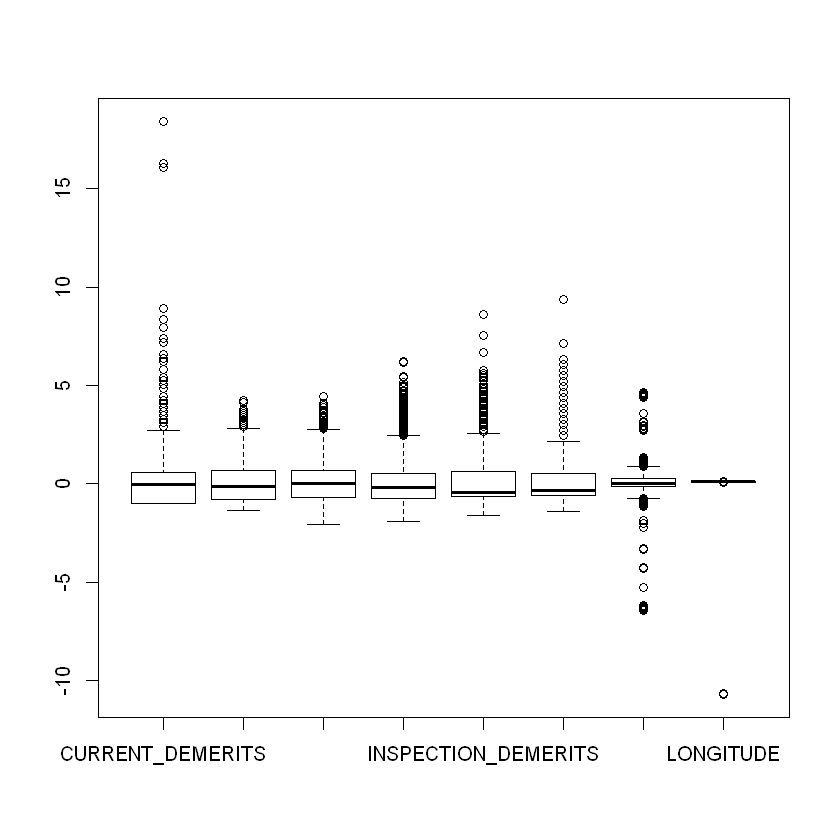

In [62]:
boxplot(df[,-c(9:14)])# check for the outliers

In [63]:
#current demerits have outliers and we need to remove it
Q <- quantile(df$CURRENT_DEMERITS, probs=c(.25, .75), na.rm = FALSE)
# calculate Interquartile Range
iqr <- IQR(df$CURRENT_DEMERITS)
#  upper and lower range
up <-  Q[2]+1.5*iqr # Upper Range  
low<- Q[1]-1.5*iqr # Lower Rangeï»¿
#  (the removal)
df<- subset(df, df$CURRENT_DEMERITS > (Q[1] - 1.5*iqr) & df$CURRENT_DEMERITS < (Q[2]+1.5*iqr))
#________________________________________________________________________________________
Q <- quantile(df$LONGITUDE, probs=c(.25, .75), na.rm = FALSE)
# calculate Interquartile Range
iqr <- IQR(df$LONGITUDE)
#  upper and lower range
up <-  Q[2]+1.5*iqr # Upper Range  
low<- Q[1]-1.5*iqr # Lower Rangeï»¿
#  (the removal)
df<- subset(df, df$LONGITUDE > (Q[1] - 1.5*iqr) & df$LONGITUDE < (Q[2]+1.5*iqr))
#________________________________________________________________________________________

#INSPECTION_DEMERITS is highly correlated WITH NUMBER_OF_VIOLATIONS thus we will drop it
df = subset(df, select = -c(INSPECTION_DEMERITS))

## Preparation of test data before we predict

In [64]:
# reading the datasets
pred_data<-read.csv("C:/Users/Anurag/Desktop/code challenge/Open-Ended Modeling Assessment Data Files/TEST_SET.csv", header=T, na.strings=c(" ","","NA"))#any spaces or blanks will be assigned to NA

splitting the raw columns

In [65]:
#SPLIT column LAT_LONG_RAW to longitude and latitude
pred_data<- cSplit(pred_data, "LAT_LONG_RAW", ", ")
pred_data$LATITUDE = str_remove_all(pred_data$LAT_LONG_RAW_1, "[(]")#removed bracket from the latitude
pred_data$LONGITUDE = str_remove_all(pred_data$LAT_LONG_RAW_2, "[)]")#removed bracket from the longitude

In [66]:
levels(pred_data$FIRST_VIOLATION_TYPE)#this column has a different level as "1"
pred_data[pred_data$FIRST_VIOLATION_TYPE==1, "FIRST_VIOLATION_TYPE"] <- "Other" #replace the factor "1" with "Other"

[1] "1"         "Critical"  "Major"     "Non-Major"

Checking for the correct column type in the data

In [67]:
sapply(pred_data, class)

#TRANSFORMING factor type column to numeric data
pred_data<-transform(pred_data, LATITUDE = as.numeric(as.character(LATITUDE)),
                      LONGITUDE = as.numeric(as.character(LONGITUDE)))

RESTAURANT_SERIAL_NUMBER RESTAURANT_PERMIT_NUMBER          RESTAURANT_NAME 
                "factor"                 "factor"                 "factor" 
     RESTAURANT_LOCATION      RESTAURANT_CATEGORY                  ADDRESS 
                "factor"                 "factor"                 "factor" 
                    CITY                    STATE                      ZIP 
                "factor"                 "factor"                 "factor" 
        CURRENT_DEMERITS            CURRENT_GRADE          INSPECTION_TIME 
               "integer"                 "factor"                 "factor" 
         INSPECTION_TYPE      INSPECTION_DEMERITS           VIOLATIONS_RAW 
                "factor"                "integer"                 "factor" 
          RECORD_UPDATED          FIRST_VIOLATION         SECOND_VIOLATION 
                "factor"                "integer"                "integer" 
         THIRD_VIOLATION     FIRST_VIOLATION_TYPE    SECOND_VIOLATION_TYPE 
               "integer"                 "factor"                 "factor" 
    THIRD_VIOLATION_TYPE     NUMBER_OF_VIOLATIONS           EMPLOYEE_COUNT 
                "factor"                "integer"                "numeric" 
     MEDIAN_EMPLOYEE_AGE   MEDIAN_EMPLOYEE_TENURE           LAT_LONG_RAW_1 
               "numeric"                "numeric"                 "factor" 
          LAT_LONG_RAW_2                 LATITUDE                LONGITUDE 
                "factor"              "character"              "character"

iNSPECTION_time has YEAR which can not be 1900, it is a false entry.
Number of Violations validation and updating with the raw violation data

In [68]:
#uSING column VIOLATIONS_RAW for calculation of number of violations to fill missing values and recheck the sum
NO_OF_VIOLATIONS_UPDATED_t<- c()
i=1
for (value in pred_data$VIOLATIONS_RAW) {
  NO_OF_VIOLATIONS_UPDATED_t[i]<- length(unlist(strsplit(as.character(value), ",")))
  i=i+1
}

pred_data$NUMBER_OF_VIOLATIONS<-NO_OF_VIOLATIONS_UPDATED_t

column INSPECTION_TYPE has a new level which will be replaced by "Other"

In [69]:
levels(pred_data$INSPECTION_TYPE)# a different category added as "Epidemiological Investigation" replaced by "Other"

[1] "Epidemiological Investigation" "Re-inspection"                
[3] "Routine Inspection"

In [70]:
pred_data[pred_data$INSPECTION_TYPE=="Epidemiological Investigation", "INSPECTION_TYPE"]<- "Other"

colSums(is.na(pred_data))

RESTAURANT_SERIAL_NUMBER RESTAURANT_PERMIT_NUMBER          RESTAURANT_NAME 
                       0                        0                        0 
     RESTAURANT_LOCATION      RESTAURANT_CATEGORY                  ADDRESS 
                       1                        0                        2 
                    CITY                    STATE                      ZIP 
                       3                        0                        2 
        CURRENT_DEMERITS            CURRENT_GRADE          INSPECTION_TIME 
                       0                        2                        3 
         INSPECTION_TYPE      INSPECTION_DEMERITS           VIOLATIONS_RAW 
                       0                        0                        0 
          RECORD_UPDATED          FIRST_VIOLATION         SECOND_VIOLATION 
                       0                        0                        0 
         THIRD_VIOLATION     FIRST_VIOLATION_TYPE    SECOND_VIOLATION_TYPE 
                       0                        0                        0 
    THIRD_VIOLATION_TYPE     NUMBER_OF_VIOLATIONS           EMPLOYEE_COUNT 
                       0                        0                        0 
     MEDIAN_EMPLOYEE_AGE   MEDIAN_EMPLOYEE_TENURE           LAT_LONG_RAW_1 
                       0                        0                        0 
          LAT_LONG_RAW_2                 LATITUDE                LONGITUDE 
                       0                        0                        0

Remove unwanted columns later - CURRENT_GRADE

In [71]:
#remove unwanted columns 
testing = subset(pred_data, select = -c(RESTAURANT_SERIAL_NUMBER, RESTAURANT_PERMIT_NUMBER, RESTAURANT_NAME, RESTAURANT_LOCATION, ADDRESS,ZIP, LAT_LONG_RAW_1, LAT_LONG_RAW_2, VIOLATIONS_RAW, RECORD_UPDATED, FIRST_VIOLATION, SECOND_VIOLATION, THIRD_VIOLATION, CITY,INSPECTION_TIME,STATE,CURRENT_GRADE,INSPECTION_DEMERITS))

Checking any NA values left in the testing data

In [72]:
colSums(is.na(testing))

RESTAURANT_CATEGORY       CURRENT_DEMERITS        INSPECTION_TYPE 
                     0                      0                      0 
  FIRST_VIOLATION_TYPE  SECOND_VIOLATION_TYPE   THIRD_VIOLATION_TYPE 
                     0                      0                      0 
  NUMBER_OF_VIOLATIONS         EMPLOYEE_COUNT    MEDIAN_EMPLOYEE_AGE 
                     0                      0                      0 
MEDIAN_EMPLOYEE_TENURE               LATITUDE              LONGITUDE 
                     0                      0                      0

Normalization

In [73]:
#Normalize testing main data: 
testing_norm <- normalize(testing[,-c(1,3:6)], method = "standardize", range = c(0, 1), margin = 1L, on.constant = "quiet")
testing<- data.frame(testing_norm, RESTAURANT_CATEGORY=testing$RESTAURANT_CATEGORY, INSPECTION_TYPE=testing$INSPECTION_TYPE, FIRST_VIOLATION_TYPE= testing$FIRST_VIOLATION_TYPE, SECOND_VIOLATION_TYPE=testing$SECOND_VIOLATION_TYPE, THIRD_VIOLATION_TYPE=testing$THIRD_VIOLATION_TYPE)
# to take a brief look at the new values
testing_cols<- sapply(testing, is.numeric)#numeric columns
testing_summarization<-(testing[, testing_cols])
summary(testing_summarization)#summary of the numeric columns

 CURRENT_DEMERITS      NUMBER_OF_VIOLATIONS EMPLOYEE_COUNT       
 Min.   :-1.01176192   Min.   :-0.8884620   Min.   :-1.37816516  
 1st Qu.:-1.01176192   1st Qu.:-0.6122438   1st Qu.:-0.81722665  
 Median :-0.01312007   Median :-0.3360256   Median :-0.06500245  
 Mean   : 0.00000000   Mean   : 0.0000000   Mean   : 0.00000000  
 3rd Qu.: 0.58606505   3rd Qu.: 0.4926290   3rd Qu.: 0.67769240  
 Max.   :18.96107523   Max.   :10.9889201   Max.   : 4.24519745  
 MEDIAN_EMPLOYEE_AGE   MEDIAN_EMPLOYEE_TENURE    LATITUDE           
 Min.   :-2.04004839   Min.   :-1.8129368     Min.   :-59.42338562  
 1st Qu.:-0.70195108   1st Qu.:-0.7282525     1st Qu.: -0.01692655  
 Median :-0.01902446   Median :-0.1597257     Median :  0.01947630  
 Mean   : 0.00000000   Mean   : 0.0000000     Mean   :  0.00000000  
 3rd Qu.: 0.67528267   3rd Qu.: 0.5366080     3rd Qu.:  0.08829510  
 Max.   : 4.31638367   Max.   : 8.1107082     Max.   :  1.18885290  
   LONGITUDE         
 Min.   :-9.6092033  
 1st Qu.: 0

Add prediction column with a default value 1 so that model does not give an error for having a null value.

In [74]:
testing$NEXT_INSPECTION_GRADE_C_OR_BELOW<- 1

Rearranging the columns in the test data to match the arrangement with training data.

In [75]:
testing<- testing[,c(1,3,4,5,2,6:13)]
testing$NEXT_INSPECTION_GRADE_C_OR_BELOW<- as.numeric(testing$NEXT_INSPECTION_GRADE_C_OR_BELOW)

In [76]:
colSums(is.na(testing))

CURRENT_DEMERITS                   EMPLOYEE_COUNT 
                               0                                0 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                               0                                0 
            NUMBER_OF_VIOLATIONS                         LATITUDE 
                               0                                0 
                       LONGITUDE              RESTAURANT_CATEGORY 
                               0                                0 
                 INSPECTION_TYPE             FIRST_VIOLATION_TYPE 
                               0                                0 
           SECOND_VIOLATION_TYPE             THIRD_VIOLATION_TYPE 
                               0                                0 
NEXT_INSPECTION_GRADE_C_OR_BELOW 
                               0

In [77]:
colSums(is.na(df))

CURRENT_DEMERITS                   EMPLOYEE_COUNT 
                               0                                0 
             MEDIAN_EMPLOYEE_AGE           MEDIAN_EMPLOYEE_TENURE 
                               0                                0 
            NUMBER_OF_VIOLATIONS                         LATITUDE 
                               0                                0 
                       LONGITUDE              RESTAURANT_CATEGORY 
                               0                                0 
                 INSPECTION_TYPE             FIRST_VIOLATION_TYPE 
                               0                                0 
           SECOND_VIOLATION_TYPE             THIRD_VIOLATION_TYPE 
                               0                                0 
NEXT_INSPECTION_GRADE_C_OR_BELOW 
                               0

## KNN Prediction model

In [78]:
# The knn function is available in the class package
Predictions_main <- knn(df[-c(8:12)], testing[-c(8:12)], cl = df$NEXT_INSPECTION_GRADE_C_OR_BELOW, k=3)

Adding the predicted values to the testing data and replacing the default values. The column CLASSIFIER_PROBABILITY is left blank as the KNN is not a probalistic model and thus it can not generate probability of classification like other models like logistic regression model.

In [79]:
testing$NEXT_INSPECTION_GRADE_C_OR_BELOW<- Predictions_main

In [80]:
predictions_Jha_Anurag_Intern<- data.frame(RESTAURANT_SERIAL_NUMBER= pred_data$RESTAURANT_SERIAL_NUMBER, CLASSIFIER_PREDICTION= Predictions_main, CLASSIFIER_PROBABILITY=NA)

Exporting the file

In [81]:
#write.csv(predictions_Jha_Anurag_Intern,"C:/Users/Anurag/Desktop/code challenge/predictions_Jha_Anurag_Intern.csv", row.names = FALSE)

## Future Recommendations

##### Increasing number of features
Columns like: "Online orders available or not", "Table book option availability", "Contains phone number of the restaurant", "number of customers daily average", and "(transformed) revenue average"
can act as a significant variable in prediction model.

Some columns with factors can be processed with "one hot encoding" to form (n-1) columns for n levels of the column which can be numerical and yet won't show bias among the factors due to numerical conversion. That will have higher chances of increment in model accuracy in KNN as KNN takes only numerical input.

The columns First violation, Second Violation, and Third Violation can be changed to various columns for each type of violation with two factors of 1- for presence of that violation, and 0- for absence of that violation.
Adding more data will have higher flexibility in the model and decrease the bias.

##### Category based ML models
We can make seperate models for each restaurant category (around 30 different ML models) and make a loop(ifelse) in which the specific prediction model will predict in ifelse statement matching the category of restaurant in the test data. That will require a little extra work and time for completion and will give better accuracy.

##### Adding more data
We can request for more data to train our model to make it more generalized and flexible.

##### Feature Selection
After addition of features, conduction of feature selection will remove in-informative features. Regularization is the best way to use as few features as possible.

##### Ensemble methods
Bagging or Boosting- It will require more computational power but will decrease any bias and will do a little effect on variance.

##### Trying various other ML models with Hyperparameter Tuning

##### Predicted missing value imputation
We imputed median values in the missing spaces of the column but imputation by prediction modeling within the column can help in better and more accurate imputation of the missing values. This can be achieved with an adjacent row which is related to the row we need to predict. We can use KNN or Linear regression to predict and impute the missing values.

Outliers can be treated as missing values instead of removing the complete rows.

##### Multiple ML algorithms

The ideal ML algorithm can give the best accuracy but to get there, we should use all relevant models and perform hyperparameter tuning for each model.

##### Crossvalidation

K-fold cross validation will help in multiple validation of the accuracy and we can make sure that the current accuracy achieved is not a fluke.
